In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.patches import Patch
import matplotlib as mpl
from scipy.stats import pearsonr
font_manager.fontManager.addfont("./data/arial/ARIAL.TTF")
font_manager.fontManager.addfont("./data/arial/ARIALBD.TTF")

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'Arial',          # or 'sans-serif' if required by the journal
    'font.size': 12,                 # main font size
    'axes.labelsize': 13,            # axis labels
    'axes.titlesize': 13,            # title
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

INPUT_CSV = Path('./data/prepared_training_dataset.csv')

# Compute AP per model across all data

In [10]:
# --- Params ---
MODEL_TAGS = ['af2', 'colab', 'boltz1', 'af3']

df = pd.read_csv(INPUT_CSV)
df['binder'] = df['binder'].astype(int)
feature_cols = [c for c in df.columns if c != 'binder']

def best_ap_and_direction(vals, y):
    vals = pd.to_numeric(vals, errors='coerce').fillna(0)
    if vals.isna().all():
        return np.nan, None
    try:
        ap_high = average_precision_score(y, vals)
        ap_low  = average_precision_score(y, -vals)
    except ValueError:
        return np.nan, None
    if (not np.isnan(ap_high) and ap_high >= ap_low) or np.isnan(ap_low):
        return ap_high, False   # Higher is better
    else:
        return ap_low, True     # Lower is better

def precision_at_recall_threshold(col, y, recall_target=0.1, lower_better=False):
    col = pd.to_numeric(col, errors='coerce').fillna(0).values
    y = np.array(y)
    sorted_scores = np.sort(col) if lower_better else np.sort(col)[::-1]
    for thr in sorted_scores:
        y_pred = (col <= thr).astype(int) if lower_better else (col >= thr).astype(int)
        recall = recall_score(y, y_pred, zero_division=0)
        if recall >= recall_target:
            precision = precision_score(y, y_pred, zero_division=0)
            return precision, recall, thr
    return np.nan, np.nan, np.nan

def valid_feature_for_model(feat, model_tag, model_tags):
    """Valid if:
       - 'input' in name (but NO other model tag except model_tag)
       - or: contains model_tag and NO other model tag
    """
    tags_in_feat = [t for t in model_tags if t in feat]
    if feat.startswith("input"):
        return (len(tags_in_feat) == 0) or (len(tags_in_feat) == 1 and tags_in_feat[0] == model_tag)
    else:
        return (len(tags_in_feat) == 1 and tags_in_feat[0] == model_tag)

# --- Compute AP and direction ---
results_features = []
results_interactions = []

for tag in MODEL_TAGS:
    feats = [
        c for c in feature_cols
        if valid_feature_for_model(c, tag, MODEL_TAGS)
    ]
    feats = sorted(set(feats))
    for feat in feats:
        # Main feature
        ap, is_lower = best_ap_and_direction(df[feat], df['binder'])
        results_features.append({'model': tag, 'feature': feat, 'ap': ap, 'lower_is_better': is_lower})

    # Interaction terms (pairwise, model tag + input)
    for i, f1 in enumerate(feats):
        for f2 in feats[i+1:]:
            # Only allow interaction if both features are valid and distinct
            if (f1 == f2): continue
            name = f"{f1}*{f2}"
            v1 = pd.to_numeric(df[f1], errors='coerce').fillna(0)
            v2 = pd.to_numeric(df[f2], errors='coerce').fillna(0)
            inter = v1 * v2
            ap, is_lower = best_ap_and_direction(inter, df['binder'])
            results_interactions.append({'model': tag, 'feature': name, 'ap': ap, 'lower_is_better': is_lower})

df_feats = pd.DataFrame(results_features)
df_inters = pd.DataFrame(results_interactions)
df_feats = df_feats[~df_feats['ap'].isna()]
df_inters = df_inters[~df_inters['ap'].isna()]

In [11]:
# Use your mappings
label_map = {
    'af2':    'AF2 initial guess',
    'colab':  'ColabFold',
    'boltz1': 'Boltz-1',
    'af3':    'AF3',
}
color_map = {
    'AF2 initial guess': '#6db1ff',
    'ColabFold':         '#C0E6A4',
    'Boltz-1':           '#8EF3ED',
    'AF3':               '#00c2a8',
}

def format_feature_name(feat, model_tags):
    # Remove all model tag prefixes and 'rosetta'
    if "*" in feat:
        f1, f2 = feat.split("*")
        for mt in model_tags:
            f1 = f1.replace(mt + "_", "")
            f2 = f2.replace(mt + "_", "")
        f1 = f1.replace("rosetta_", "").replace("rosetta", "")
        f2 = f2.replace("rosetta_", "").replace("rosetta", "")
        f1 = f1.replace("dG_SASA_ratio", r'$\Delta$G/$\Delta$SASA')
        f2 = f2.replace("dG_SASA_ratio", r'$\Delta$G/$\Delta$SASA')
        f2 = f2.replace("sap_delta", r'$\Delta$SAP')
        f1 = f1.replace("sap_delta", r'$\Delta$SAP')
        f1 = f1.replace("dockQ", 'DockQ')
        return f"{f1} × {f2}"
    else:
        for mt in model_tags:
            feat = feat.replace(mt + "_", "")
        feat = feat.replace("sap_delta", r'$\Delta$SAP')
        return feat.replace("rosetta_", "").replace("rosetta", "")

model_tags = list(label_map.keys())
rows = []

# (Assumes df_feats and df_inters exist)
top_single = df_feats.sort_values('ap', ascending=False).groupby('model').first().reset_index()
top_inter  = df_inters.sort_values('ap', ascending=False).groupby('model').first().reset_index()

for _, row in top_single.iterrows():
    model_label = label_map[row['model']]
    feature_name = format_feature_name(row['feature'], model_tags)
    rows.append({'feature': feature_name, 'ap': row['ap'], 'model': model_label, 'kind': 'Single'})

for _, row in top_inter.iterrows():
    model_label = label_map[row['model']]
    feature_name = format_feature_name(row['feature'], model_tags)
    rows.append({'feature': feature_name, 'ap': row['ap'], 'model': model_label, 'kind': 'Interaction'})

df_plot = pd.DataFrame(rows)
order_map = {name: i for i, name in enumerate(color_map.keys())}
kind_order = {'Single': 0, 'Interaction': 1}
df_plot['order'] = df_plot['model'].map(order_map)
df_plot['kind_order'] = df_plot['kind'].map(kind_order)
df_plot_1 = df_plot.sort_values(['order', 'kind_order'], ascending=[True, True])
# --- Get the top 1 (best AP) single features and interaction terms per model ---
top_feats = (
    df_feats
    .sort_values('ap', ascending=False)
    .groupby('model')
    .head(1)
    .reset_index(drop=True)
)
top_inters = (
    df_inters
    .sort_values('ap', ascending=False)
    .groupby('model')
    .head(1)
    .reset_index(drop=True)
)

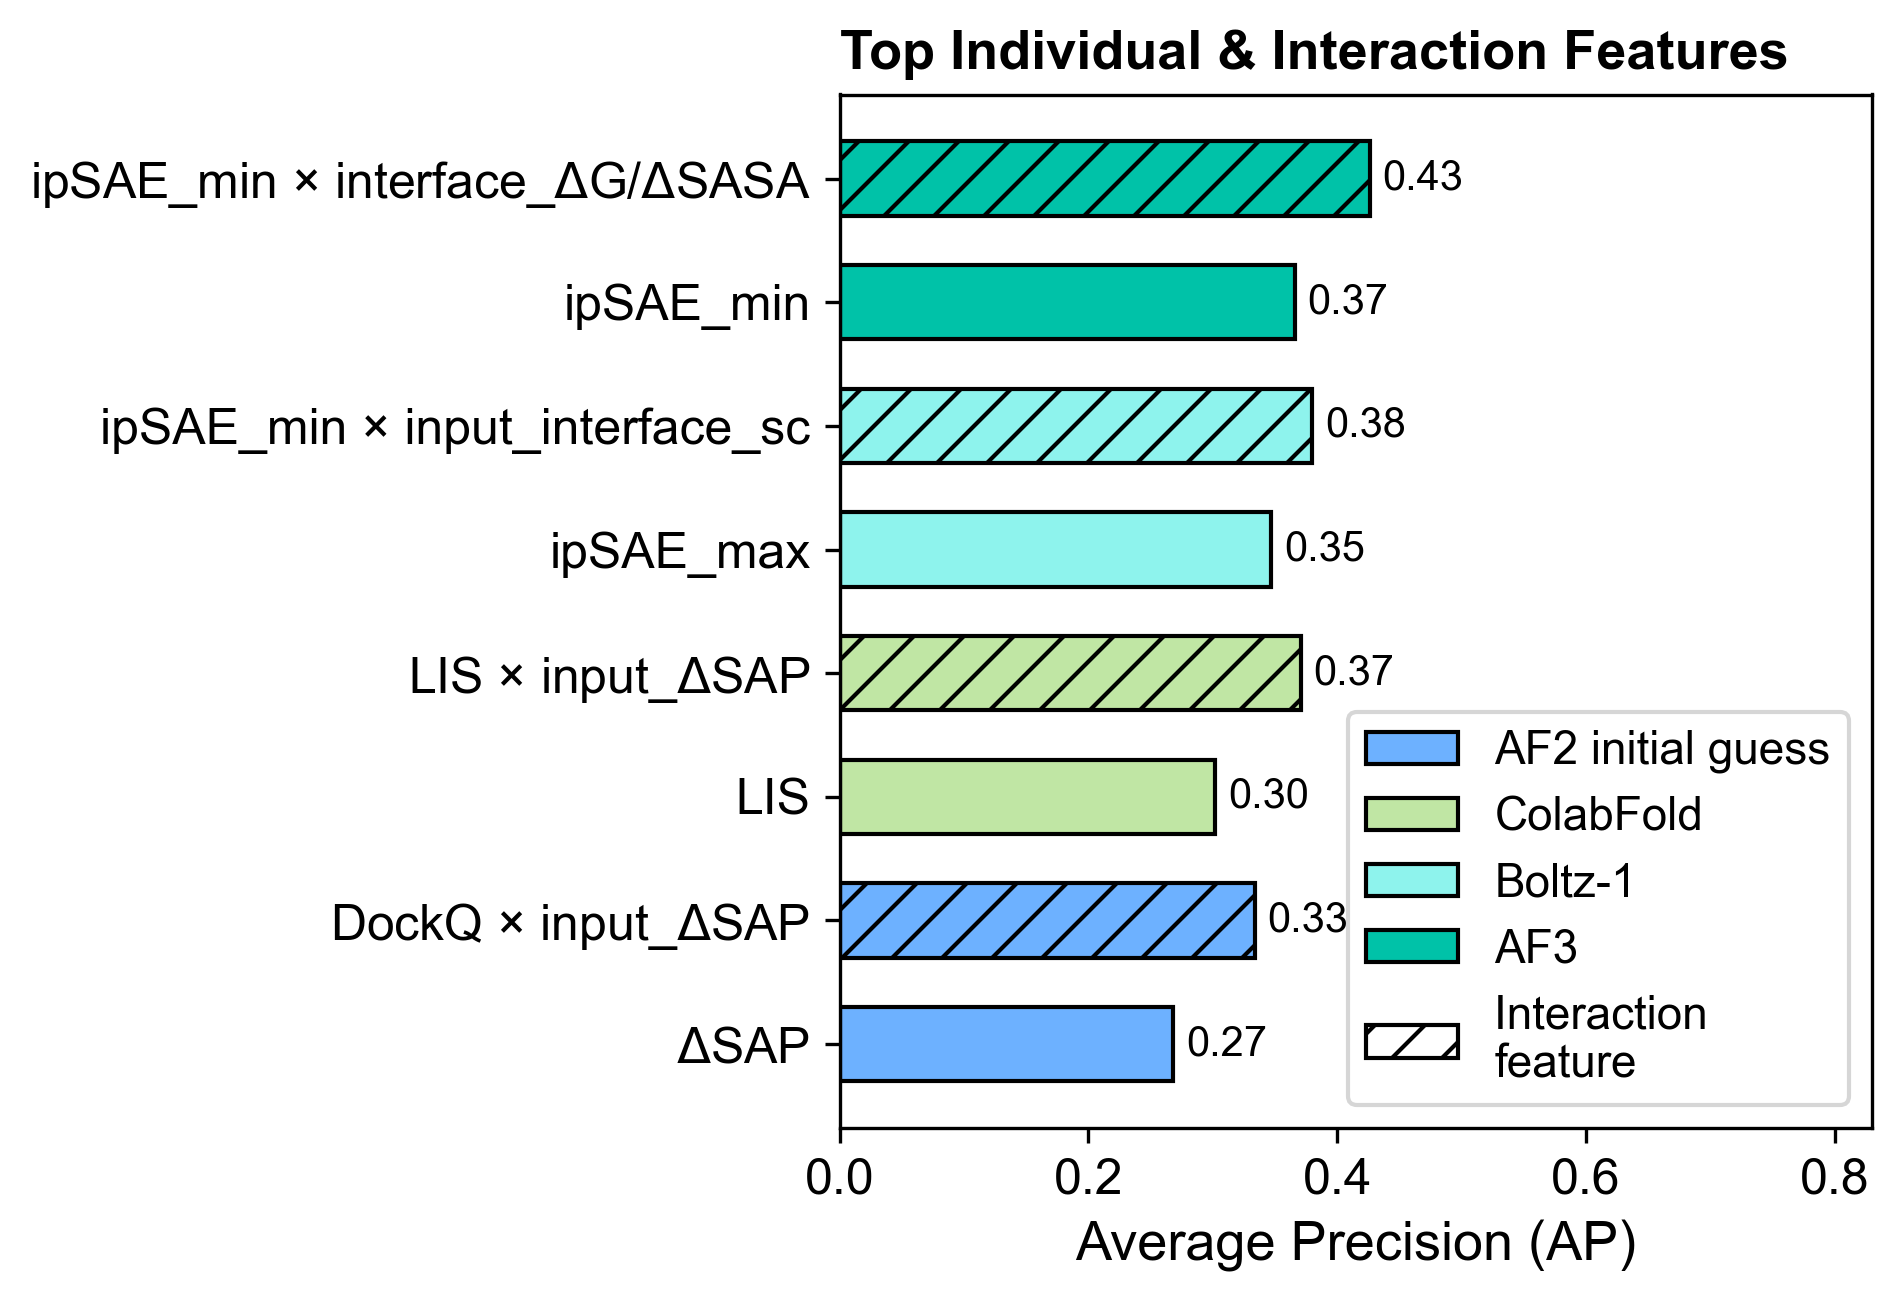

In [12]:
plt.figure(dpi=300, figsize=(6.5, 4.5))
y_pos = np.arange(len(df_plot_1))
bar_colors = [color_map[model] for model in df_plot_1['model']]

for i, (kind, color) in enumerate(zip(df_plot_1['kind'], bar_colors)):
    hatch = '//' if kind == 'Interaction' else ''
    plt.barh(i, df_plot_1['ap'].iloc[i], color=color, edgecolor='black', height=0.6, hatch=hatch)
    plt.text(df_plot_1['ap'].iloc[i] + 0.01, i, f"{df_plot_1['ap'].iloc[i]:.2f}", va='center', fontsize=10)

plt.yticks(y_pos, df_plot_1['feature'])
plt.xlabel('Average Precision (AP)')
plt.xlim(0, 0.83)
plt.title('Top Individual & Interaction Features',loc='left', fontweight='bold')

# Legend: one for model colors, one for hatch (interaction)
legend_elements = [
    Patch(facecolor=color_map[label], edgecolor='black', label=label)
    for label in color_map
]
interaction_patch = Patch(facecolor='white', edgecolor='black', hatch='//', label="Interaction \nfeature")

plt.legend(handles=legend_elements + [interaction_patch], loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()

# AF2 ipAE bias

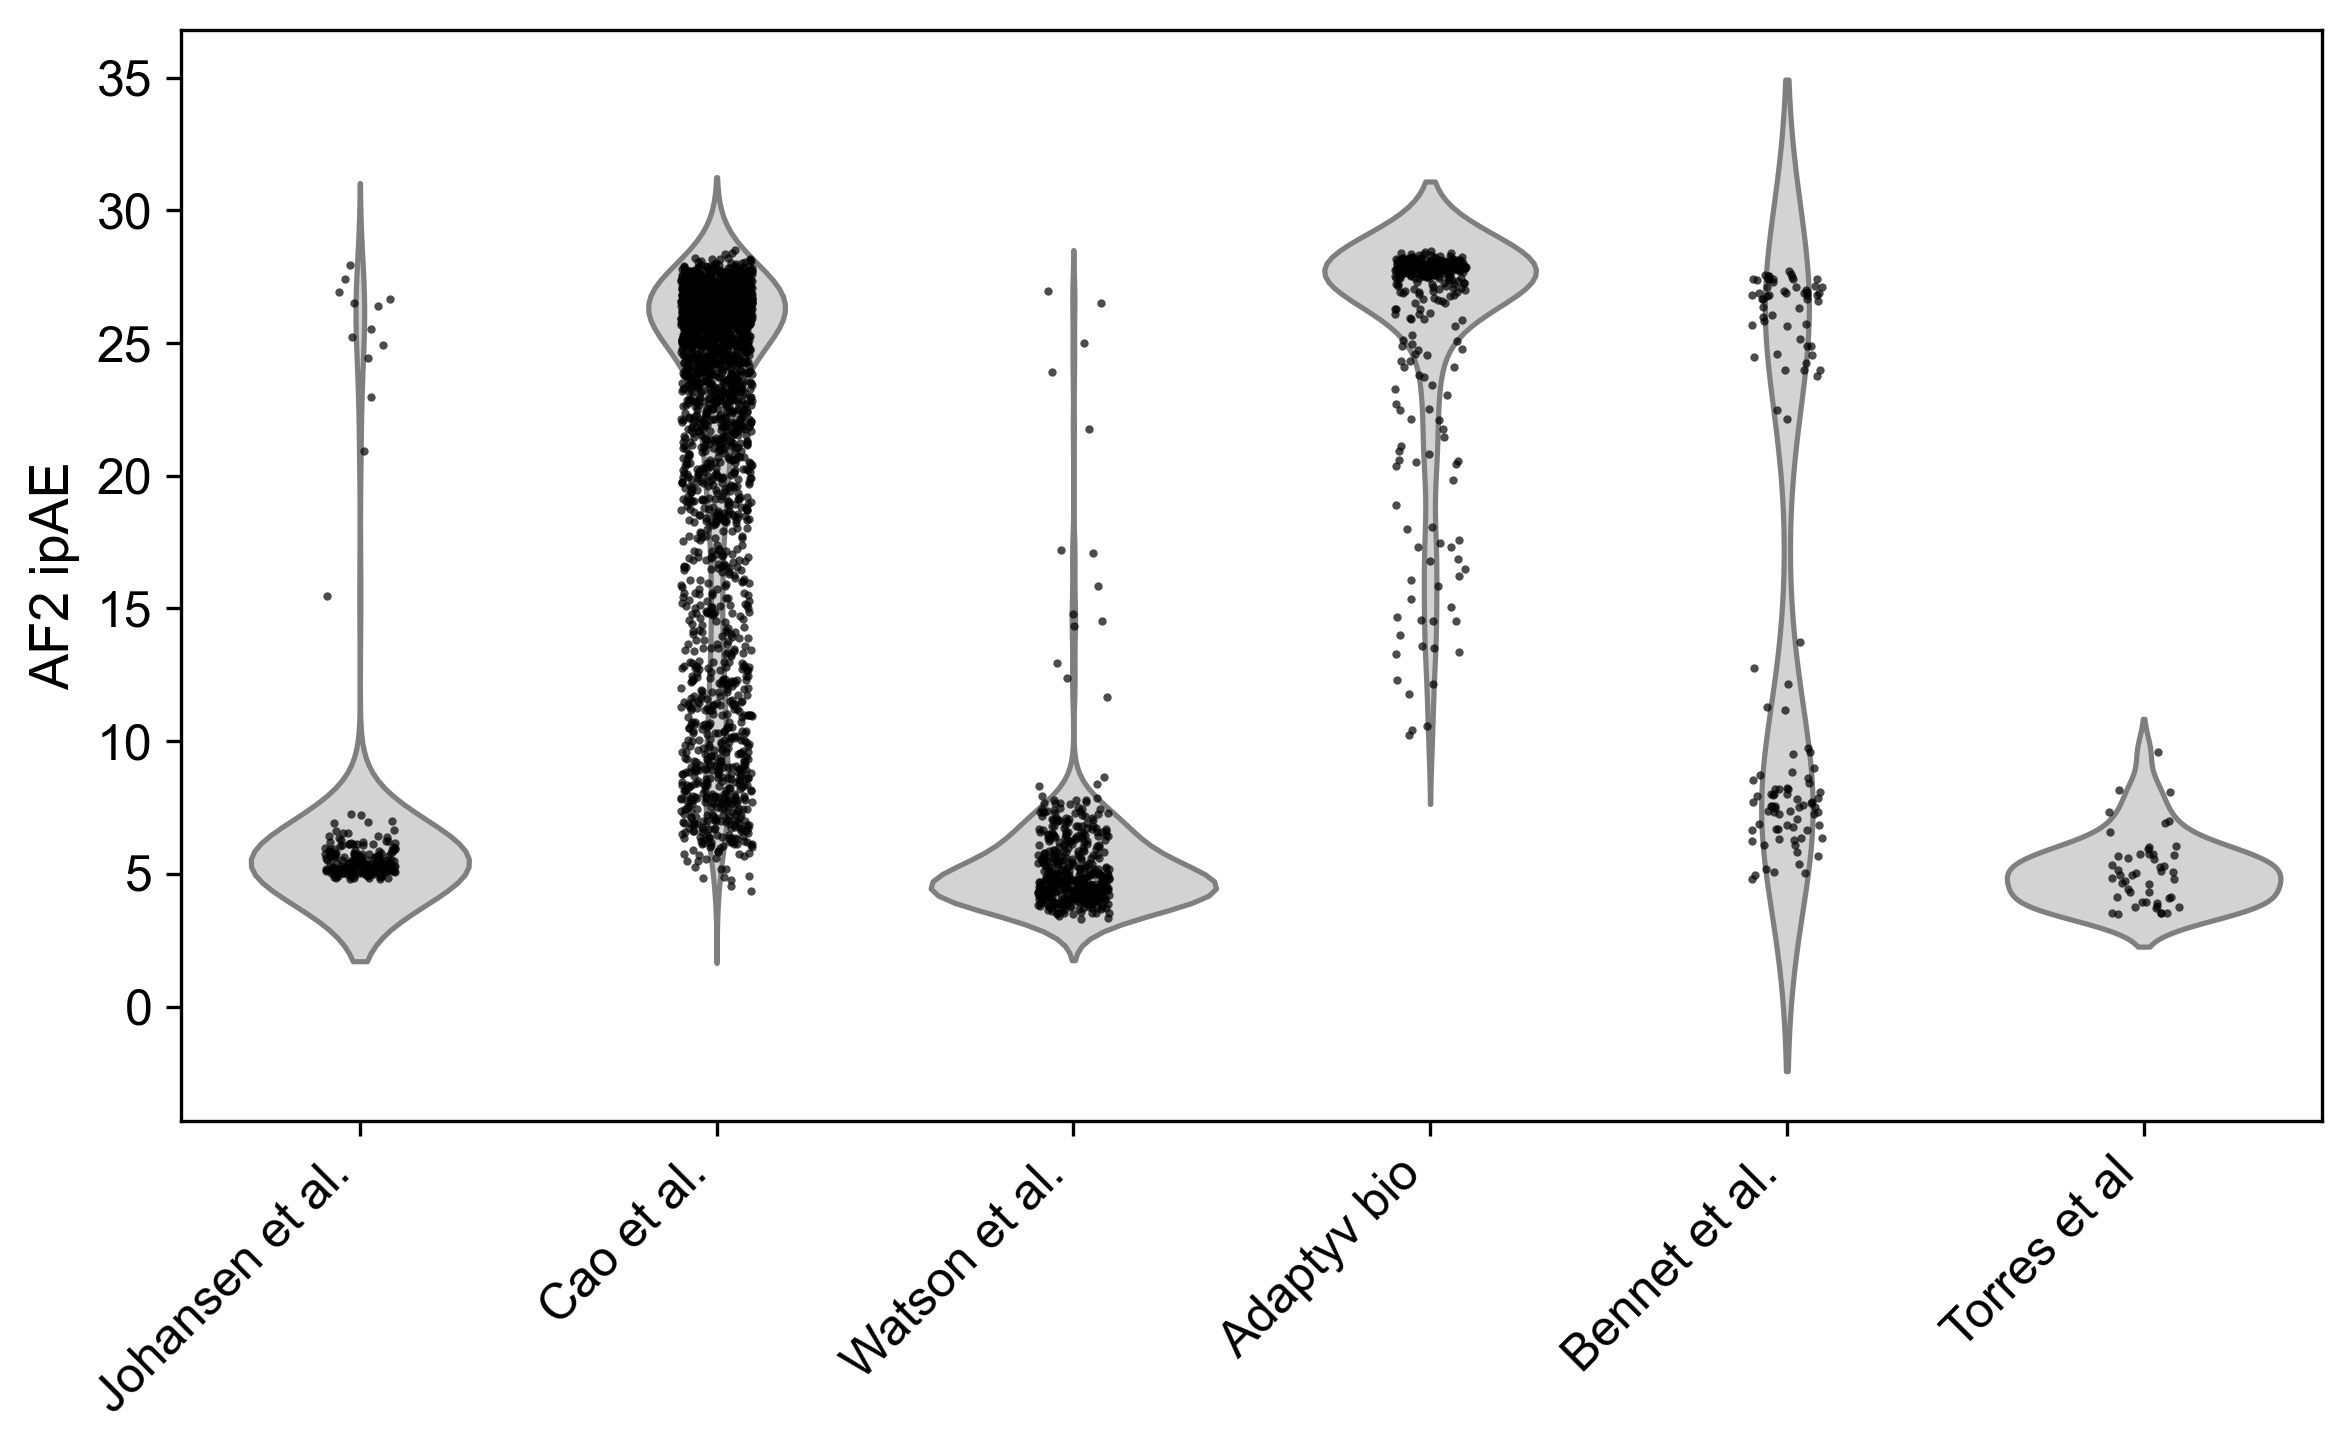

In [26]:
import seaborn as sns

df = pd.read_csv(INPUT_CSV)
# Define mapping rules
def assign_group(source):
    if 'Cao et al' in source:
        return 'Cao et al.'
    elif 'Adaptyv' in source:
        return 'Adaptyv bio'
    elif 'Watson et al' in source:
        return 'Watson et al.'
    elif 'pMHC screening' in source:
        return 'Johansen et al.'
    elif 'Bennet paper' in source:
        return 'Bennet et al.'
    elif 'Vazquez-Torres' in source:
        return 'Torres et al'
    else:
        return 'Unknown'

# Apply mapping
df['group'] = df['source'].apply(assign_group)


# Create violin plot with custom axis labels and overlaid data points
plt.figure(figsize=(8, 5), dpi=300)

# Violin plot with inner box
sns.violinplot(data=df, x='group', y='af2_pae_interaction', inner=None, color='lightgray')

# Overlay individual data points
sns.stripplot(data=df, x='group', y='af2_pae_interaction', color='black', size=2, jitter=True, alpha=0.7)

# Custom axis labels
plt.xlabel("")
plt.ylabel("AF2 ipAE")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Evaluating metrics per target

In [27]:
records = []
for tid, group in df.groupby('target_id'):
    vals_inter = (
        pd.to_numeric(group['af3_ipSAE_min'], errors='coerce').fillna(0) *
        pd.to_numeric(group['af3_rosetta_interface_dG_SASA_ratio'], errors='coerce').fillna(0)
    )
    vals_1 = pd.to_numeric(group['af3_ipSAE_min'], errors='coerce').fillna(0)
    vals_2 = pd.to_numeric(group['af3_rosetta_interface_dG_SASA_ratio'], errors='coerce').fillna(0)
    mean_dG_SASA_ratio = vals_2.mean()
    
    y = group['binder'].values
    n_true = y.sum()
    ap_inter = average_precision_score(y, -vals_inter) if len(np.unique(vals_inter)) > 1 else np.nan  # lower is better
    ap_1 = average_precision_score(y, vals_1) if len(np.unique(vals_1)) > 1 else np.nan  # higher is better
    ap_2 = average_precision_score(y, vals_2) if len(np.unique(vals_2)) > 1 else np.nan   # higher is better
    records.append({'target_id': tid, 'AP_inter': ap_inter, 'AP_ipSAE_min': ap_1, 'mean_dG_SASA_ratio': mean_dG_SASA_ratio, 'n_true': n_true})

df_plot_2 = pd.DataFrame(records).dropna()


### AF3 ipSAE_min vs ipSAE_min x interface_dG/dSASA

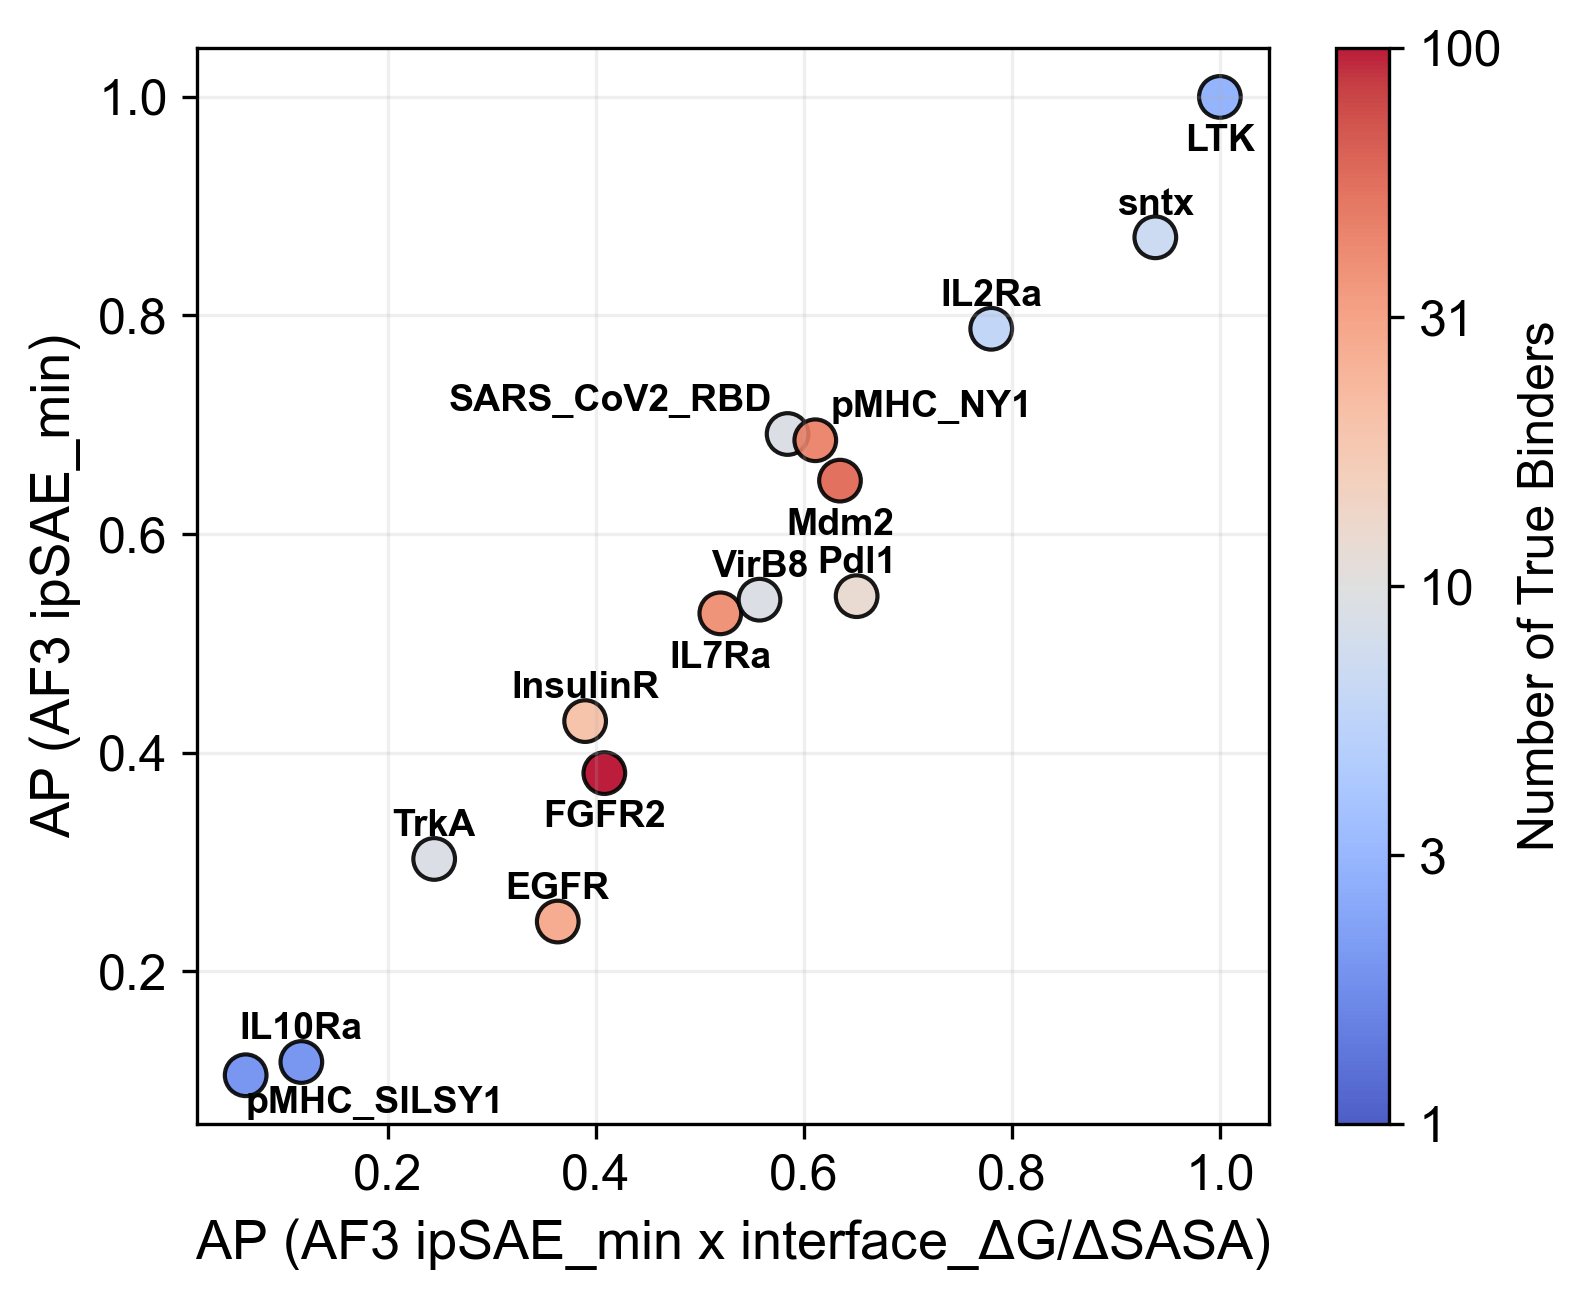

In [28]:
plt.figure(figsize=(5.5, 4.5),dpi=300)
cmap = plt.get_cmap('coolwarm')
# Use log10 for better ticks
df_plot_2['n_true_log10'] = np.log10(df_plot_2['n_true'])

bar_min, bar_max = 0, 2   # (shows all the way from 10^0=1 to 10^2=100)
norm = mpl.colors.Normalize(vmin=bar_min, vmax=bar_max)

rval, pval = pearsonr(df_plot_2['AP_inter'], df_plot_2['AP_ipSAE_min'])

sc = plt.scatter(
    df_plot_2['AP_inter'],
    df_plot_2['AP_ipSAE_min'],
    c=df_plot_2['n_true_log10'],  # Use normalized!
    cmap=cmap,
    s=100,
    alpha=0.9,
    edgecolor='k',
    norm=norm
)

# --- Settings for annotation shifts ---
shift_left = ["SARS_CoV2_RBD"]
below_point = ["FGFR2","IL7Ra","Mdm2","LTK"]
shift_right = ["pMHC_NY1"]
middle_point = ["pMHC_SILSY1"]

offset_y_above = 0.03  # Above point
offset_y_below = -0.025  # Below point
offset_x_left  = -0.015  # Shift left
offset_x_right = 0.015   # Shift right

for _, row in df_plot_2.iterrows():
    x, y = row['AP_inter'], row['AP_ipSAE_min']
    label = str(row['target_id'])
    ha = 'center'
    va = 'center'
    offset_x = 0
    offset_y = offset_y_above

    if label in below_point:
        va = 'top'
        offset_y = offset_y_below
    if label in shift_left:
        offset_x = offset_x_left
        ha = 'right'
    if label in shift_right:
        offset_x = offset_x_right
        ha = 'left'
    if label in middle_point:
        va = 'top'
        ha = 'left'
        offset_y = -0.01

    plt.text(
        x + offset_x,
        y + offset_y,
        label,
        ha=ha,
        va=va,
        fontsize=9,
        fontweight='bold',
        color='black'
    )

plt.xlabel(r"AP (AF3 ipSAE_min x interface_$\Delta$G/$\Delta$SASA)", fontsize=13)
plt.ylabel("AP (AF3 ipSAE_min)", fontsize=13)

# --- Colorbar: set the full bar and integer tick labels ---
tick_locs = np.arange(bar_min, bar_max + 0.5, 0.5)
tick_labels = [str(int(10**tick)) for tick in tick_locs]

cbar = plt.colorbar(sc)
cbar.set_label("Number of True Binders", fontsize=12)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)


plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Precision vs F1 threshold AF3 ipSAE_min

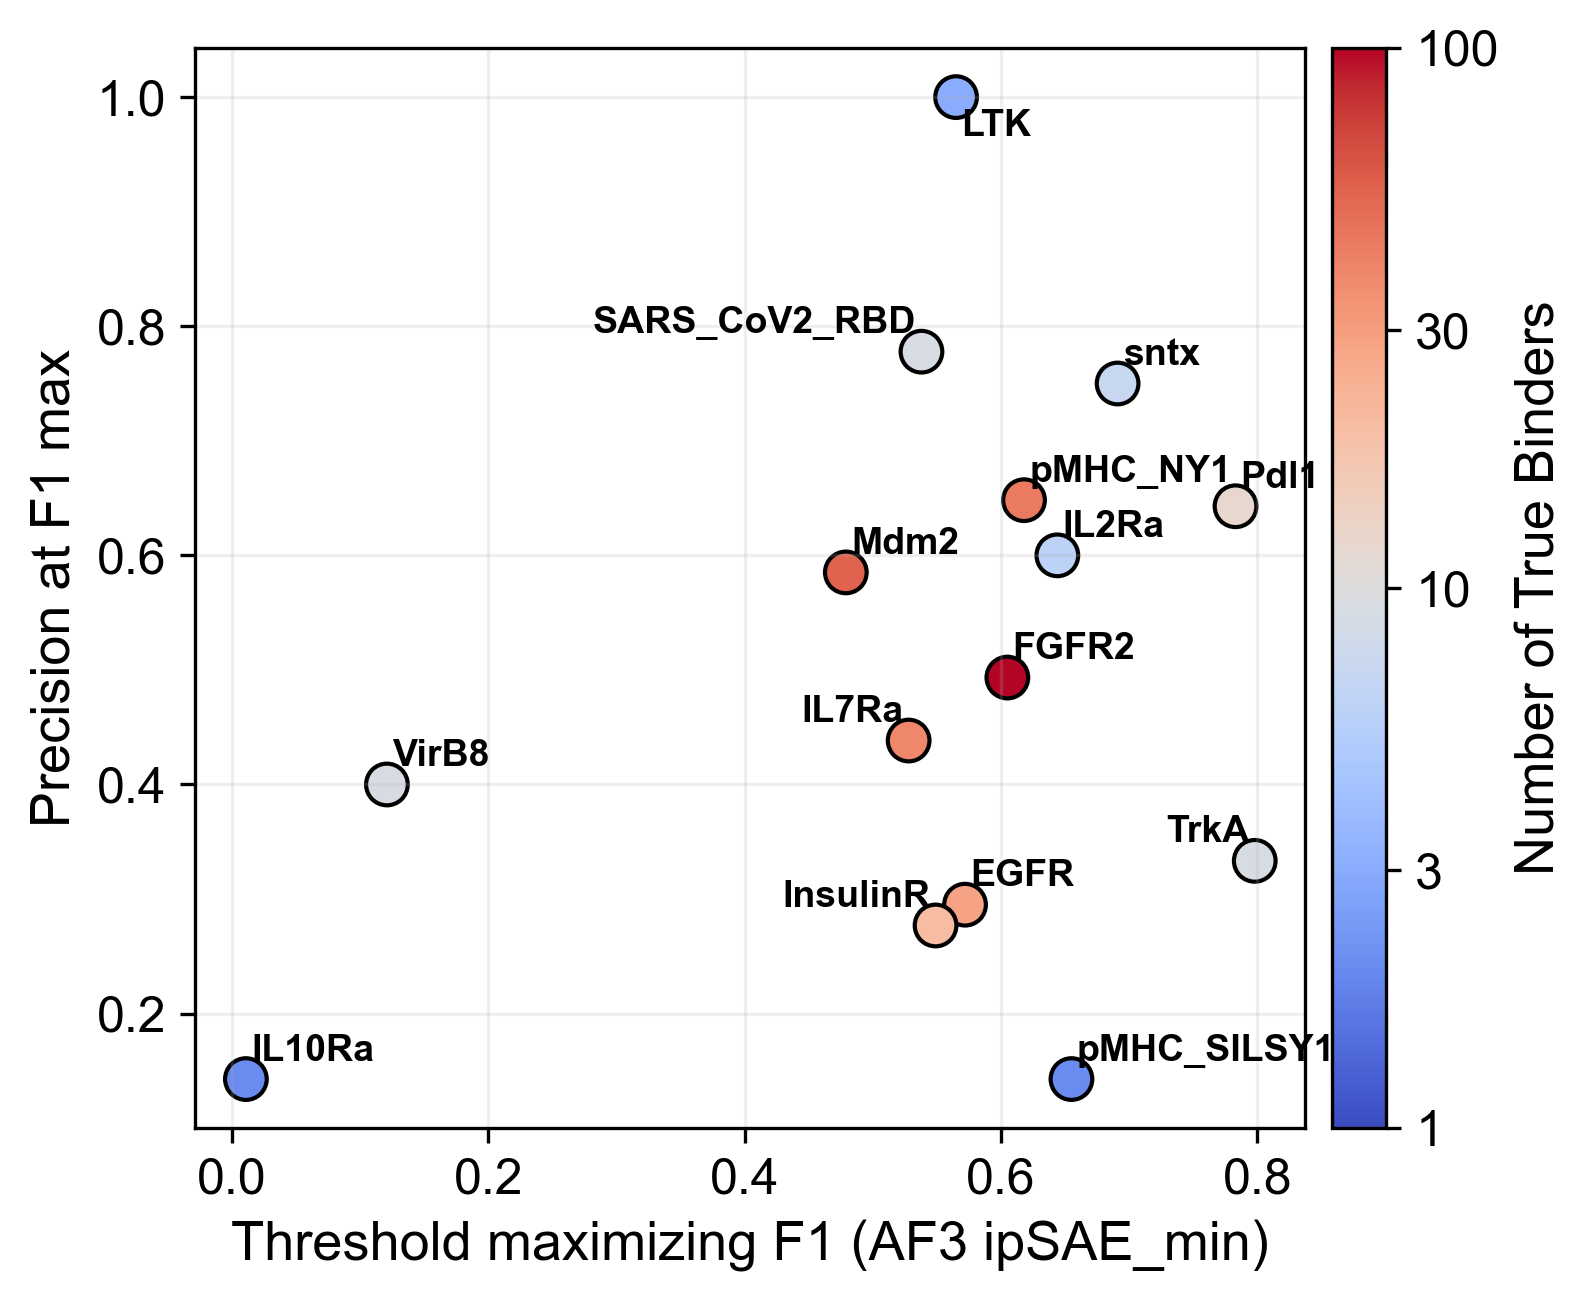

In [30]:
records = []

for tid, group in df.groupby('target_id'):
    y_true = group['binder'].values
    y_score = pd.to_numeric(group['af3_ipSAE_min'], errors='coerce').fillna(0).values

    # skip if no variation
    if len(np.unique(y_score)) <= 1:
        continue

    # find threshold that maximizes F1
    thresholds   = np.unique(y_score)
    best_f1      = -1
    best_thresh  = None

    for t in thresholds:
        y_pred = (y_score >= t).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred,
            average='binary', zero_division=0
        )
        if f1 > best_f1:
            best_f1     = f1
            best_thresh = t

    # now compute precision at that threshold
    y_pred_best    = (y_score >= best_thresh).astype(int)
    precision_best = precision_recall_fscore_support(
        y_true, y_pred_best,
        average='binary', zero_division=0
    )[0]

    # count of true positives in this target
    n_true = int(y_true.sum())

    records.append({
        'target_id':        tid,
        'precision_at_best': precision_best,
        'best_threshold':   best_thresh,
        'n_true':           n_true
    })

df_plot = pd.DataFrame(records).dropna()

# color by log10(n_true)
df_plot['n_true_log10'] = np.log10(df_plot['n_true'])

bar_min, bar_max = 0, 2   # (shows all the way from 10^0=1 to 10^2=100)
norm = mpl.colors.Normalize(vmin=bar_min, vmax=bar_max)
cmap = plt.get_cmap('coolwarm')

plt.figure(figsize=(5.5,4.5),dpi=300)
sc = plt.scatter(
    df_plot['best_threshold'],
    df_plot['precision_at_best'],
    c=df_plot['n_true_log10'],
    cmap=cmap,
    edgecolor='k',
    s=100,
    norm=norm
)

# annotate each point
for _, row in df_plot.iterrows():
    x = row['best_threshold']
    y = row['precision_at_best']
    label = row['target_id']
    dx, dy = 0.004, 0.01
    if label == "SARS_CoV2_RBD" or label == "InsulinR" or label == "IL7Ra" or label=='TrkA':
        dx, dy = -0.004, 0.01
    if label == "LTK":
        dx, dy = 0.004, -0.01
    plt.text(x+dx, y+dy, label,
             fontsize=9, fontweight='bold',
             ha='left' if dx>0 else 'right',
             va='bottom' if dy>0 else 'top')

plt.xlabel("Threshold maximizing F1 (AF3 ipSAE_min)")
plt.ylabel("Precision at F1 max")

# colorbar with ticks 1–100
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label("Number of True Binders")
cbar.set_ticks(np.log10([1,3,10,30,100]))
cbar.set_ticklabels(['1','3','10','30','100'])

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### AF2 dSAP vs ipAE

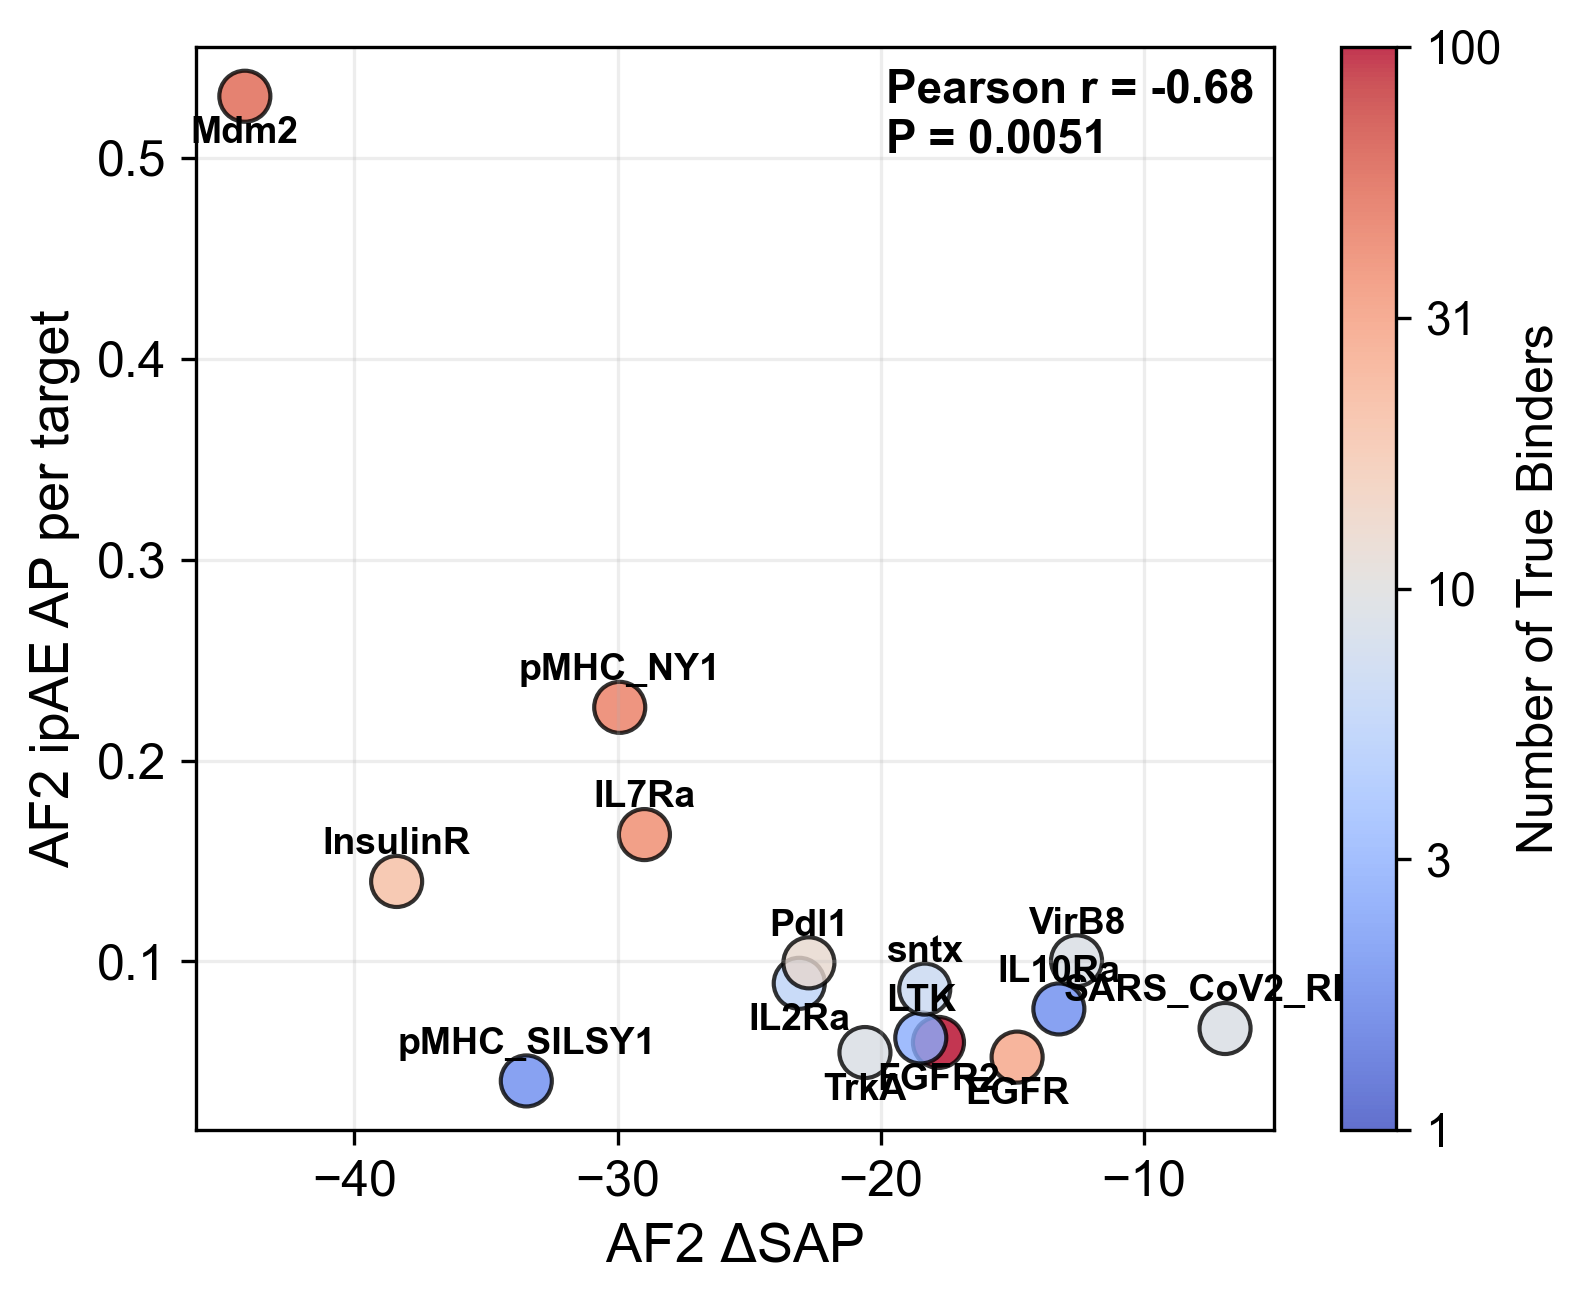

In [18]:
# Prepare data (as above, add n_true)
records = []
for tid, grp in df.groupby('target_id'):
    col = pd.to_numeric(grp['af2_pae_interaction'], errors='coerce').fillna(0)
    y = grp['binder']
    if y.nunique() < 2:
        continue
    ap = average_precision_score(y, col)
    mean_hbond = grp['af2_sap_delta'].mean()
    n_true = int(y.sum())
    records.append((tid, ap, mean_hbond, n_true))
stats = pd.DataFrame(records, columns=['target_id', 'ap', 'mean_hbond', 'n_true'])


# Clamp values to [1, 100] binders → log10 scale = [0, 2]
stats['n_true_clamped'] = stats['n_true'].clip(lower=1, upper=100)
stats['n_true_log10'] = np.log10(stats['n_true_clamped'])

# Fix color range from 1 to 100
norm = mpl.colors.Normalize(vmin=0, vmax=2)

# Use Normalize, but to fill the bar, set vmin/vmax to cover your ticks exactly
cmap = plt.get_cmap('coolwarm')

# --- Correlation ---
rval, pval = pearsonr(stats['ap'], stats['mean_hbond'])

fig, ax = plt.subplots(figsize=(5.5,4.5),dpi=300)
sc = ax.scatter(
    stats['mean_hbond'], stats['ap'],
    c=stats['n_true_log10'], cmap=cmap, s=150, edgecolor='k', alpha=0.8, norm=norm
)

# --- Annotation logic with all shifts ---
below_point = ["EGFR","Mdm2","IL2Ra","TrkA","FGFR2"]
shift_left = []

offset_y_above = 0.01
offset_y_below = -0.01
offset_x_left = -4

for idx, row in stats.iterrows():
    x = row['mean_hbond']
    y = row['ap']
    label = str(row['target_id'])
    ha = 'center'
    va = 'bottom'
    offset_x = 0
    offset_y = offset_y_above

    if label in below_point:
        va = 'top'
        offset_y = offset_y_below
    if label in shift_left:
        ha = 'center'
        offset_x = offset_x_left
        offset_y = 0

    ax.text(
        x + offset_x,
        y + offset_y,
        label,
        ha=ha,
        va=va,
        fontsize=9,
        fontweight='bold',
        color='black'
    )

ax.set_xlabel(r"AF2 $\Delta$SAP", fontsize=13)
ax.set_ylabel("AF2 ipAE AP per target", fontsize=13)

# --- Full colorbar ---
tick_locs = [0, 0.5, 1, 1.5, 2]
tick_labels = [str(int(10**tick)) for tick in tick_locs]  # ['1', '3', '10', '32', '100']


cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Number of True Binders", fontsize=12)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=11)

# --- Add correlation text ---
ax.text(
    0.64, 0.98,
    f"Pearson r = {rval:.2f}\nP = {pval:.2g}",
    transform=ax.transAxes,
    ha='left', va='top',
    fontsize=11, fontweight='bold',
    #bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.18', alpha=0.8)
)

tick_locs = np.arange(bar_min, bar_max + 0.5, 0.5)
tick_labels = [str(int(10**tick)) for tick in tick_locs]

plt.grid(alpha=0.22)
plt.tight_layout()
plt.show()

### AF3 interface H-bond vs ipSAE_min

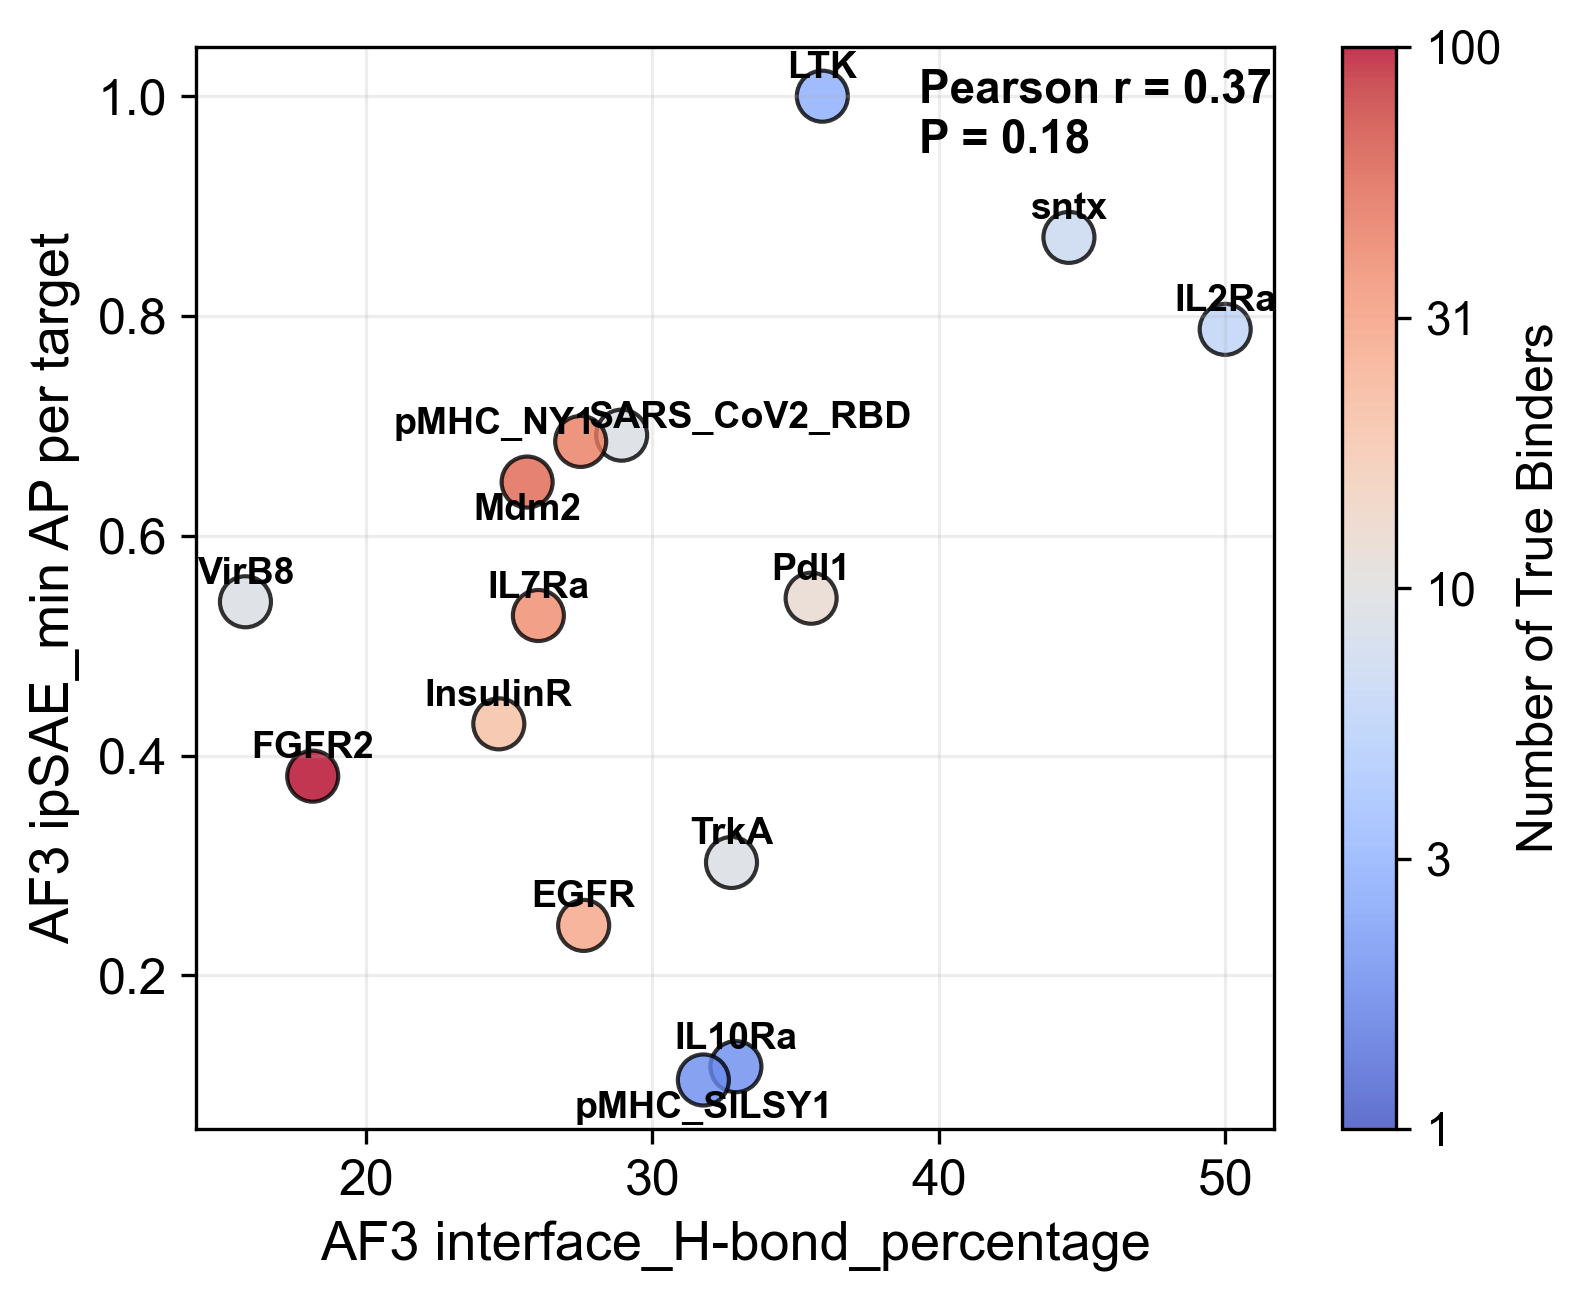

In [19]:
# Prepare data (as above, add n_true)
records = []
for tid, grp in df.groupby('target_id'):
    col = pd.to_numeric(grp['af3_ipSAE_min'], errors='coerce').fillna(0)
    y = grp['binder']
    if y.nunique() < 2:
        continue
    ap = average_precision_score(y, col)
    mean_hbond = grp['af3_rosetta_interface_hbond_percentage'].mean()
    n_true = int(y.sum())
    records.append((tid, ap, mean_hbond, n_true))
stats = pd.DataFrame(records, columns=['target_id', 'ap', 'mean_hbond', 'n_true'])


# Clamp values to [1, 100] binders → log10 scale = [0, 2]
stats['n_true_clamped'] = stats['n_true'].clip(lower=1, upper=100)
stats['n_true_log10'] = np.log10(stats['n_true_clamped'])

# Fix color range from 1 to 100
norm = mpl.colors.Normalize(vmin=0, vmax=2)

# Use Normalize, but to fill the bar, set vmin/vmax to cover your ticks exactly
cmap = plt.get_cmap('coolwarm')

# --- Correlation ---
rval, pval = pearsonr(stats['ap'], stats['mean_hbond'])

fig, ax = plt.subplots(figsize=(5.5,4.5),dpi=300)
sc = ax.scatter(
    stats['mean_hbond'], stats['ap'],
    c=stats['n_true_log10'], cmap=cmap, s=150, edgecolor='k', alpha=0.8, norm=norm
)

# --- Annotation logic with all shifts ---
below_point = ["pMHC_SILSY1","Mdm2"]
shift_left = ["pMHC_NY1"]
shift_right = ["SARS_CoV2_RBD"]

offset_y_above = 0.01
offset_y_below = -0.01
offset_x_left = -3
offset_x_right = 4.5

for idx, row in stats.iterrows():
    x = row['mean_hbond']
    y = row['ap']
    label = str(row['target_id'])
    ha = 'center'
    va = 'bottom'
    offset_x = 0
    offset_y = offset_y_above

    if label in below_point:
        va = 'top'
        offset_y = offset_y_below
    if label in shift_left:
        ha = 'center'
        offset_x = offset_x_left
        offset_y = 0
    if label in shift_right:
        ha = 'center'
        offset_x = offset_x_right
        offset_y = 0

    ax.text(
        x + offset_x,
        y + offset_y,
        label,
        ha=ha,
        va=va,
        fontsize=9,
        fontweight='bold',
        color='black'
    )

ax.set_xlabel(r"AF3 interface_H-bond_percentage", fontsize=13)
ax.set_ylabel("AF3 ipSAE_min AP per target", fontsize=13)

# --- Full colorbar ---
tick_locs = [0, 0.5, 1, 1.5, 2]
tick_labels = [str(int(10**tick)) for tick in tick_locs]  # ['1', '3', '10', '32', '100']


cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Number of True Binders", fontsize=12)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=11)

# --- Add correlation text ---
ax.text(
    0.67, 0.98,
    f"Pearson r = {rval:.2f}\nP = {pval:.2g}",
    transform=ax.transAxes,
    ha='left', va='top',
    fontsize=11, fontweight='bold',
    #bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.18', alpha=0.8)
)

tick_locs = np.arange(bar_min, bar_max + 0.5, 0.5)
tick_labels = [str(int(10**tick)) for tick in tick_locs]

plt.grid(alpha=0.22)
plt.tight_layout()
plt.show()

### AF3 dG/SASA vs ipSAE_min

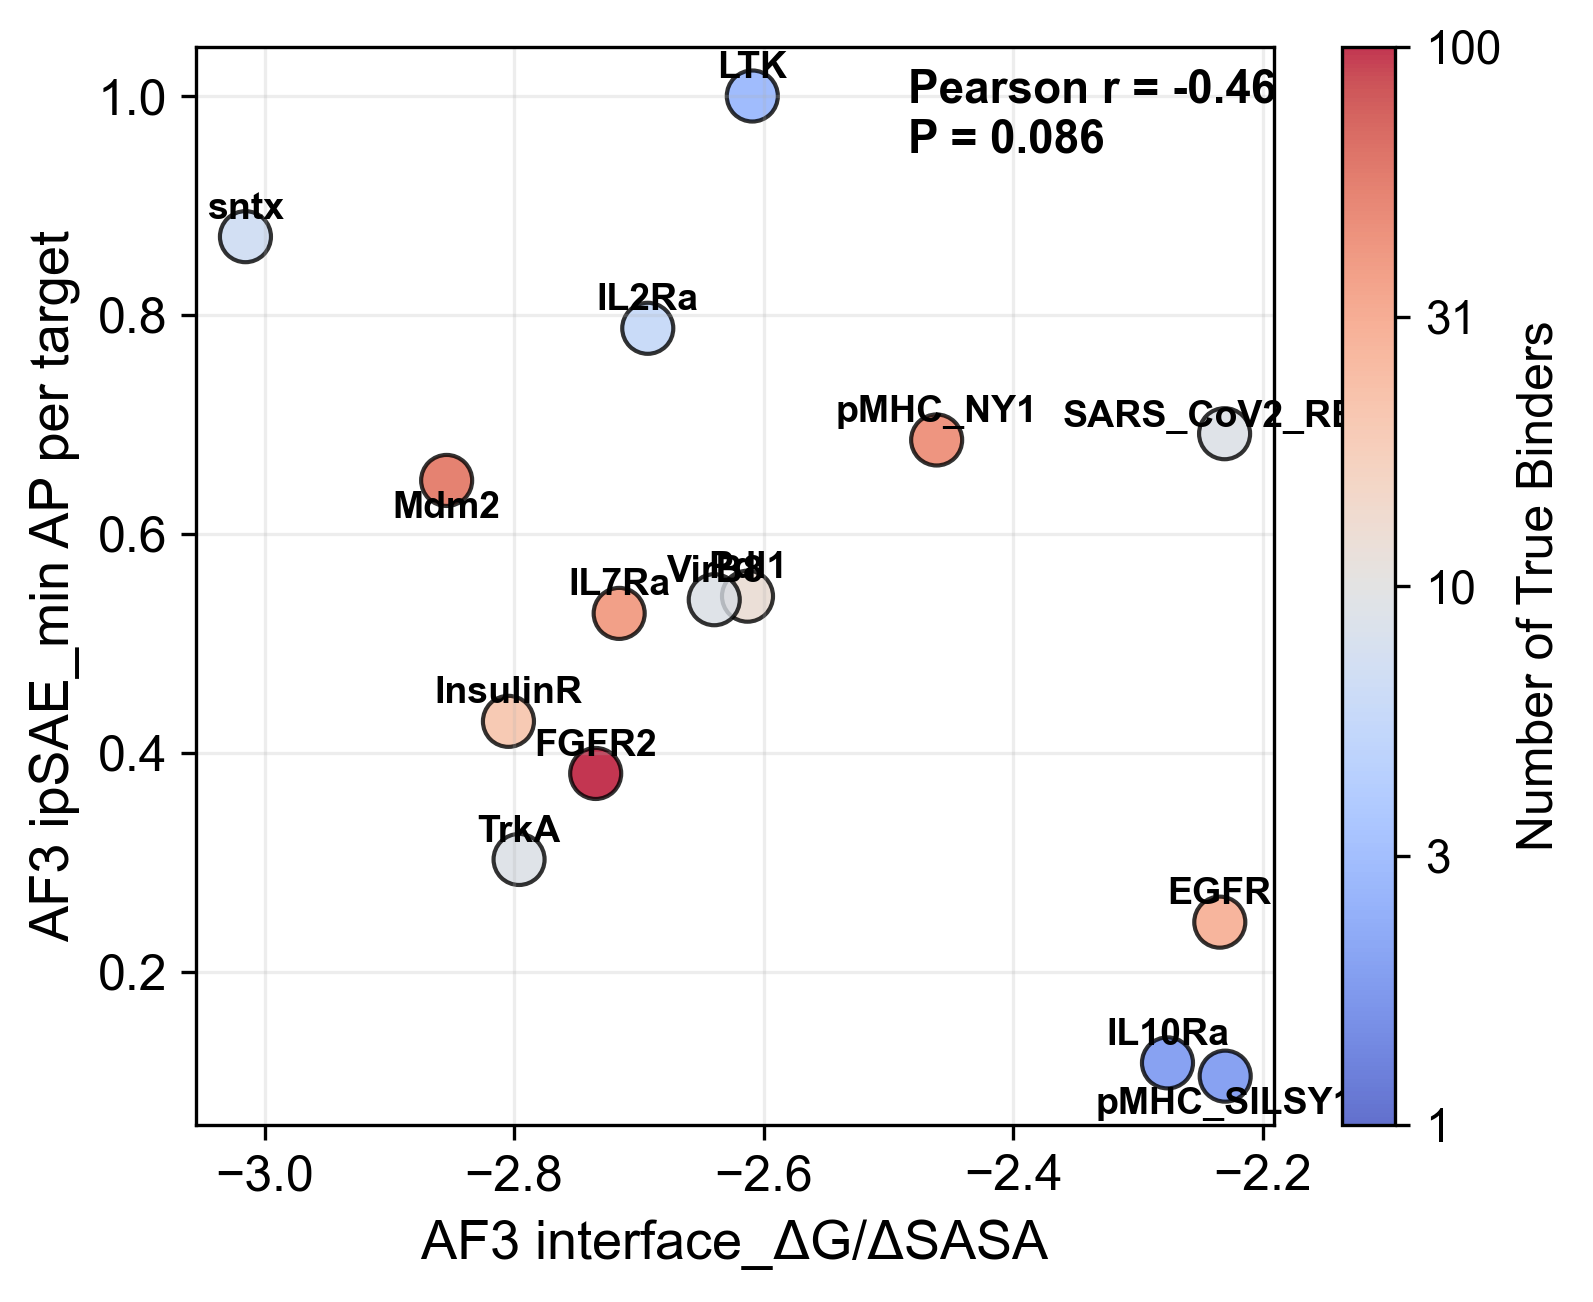

In [20]:
# Prepare data (as above, add n_true)
records = []
for tid, grp in df.groupby('target_id'):
    col = pd.to_numeric(grp['af3_ipSAE_min'], errors='coerce').fillna(0)
    y = grp['binder']
    if y.nunique() < 2:
        continue
    ap = average_precision_score(y, col)
    mean_hbond = grp['af3_rosetta_interface_dG_SASA_ratio'].mean()
    n_true = int(y.sum())
    records.append((tid, ap, mean_hbond, n_true))
stats = pd.DataFrame(records, columns=['target_id', 'ap', 'mean_hbond', 'n_true'])


# Clamp values to [1, 100] binders → log10 scale = [0, 2]
stats['n_true_clamped'] = stats['n_true'].clip(lower=1, upper=100)
stats['n_true_log10'] = np.log10(stats['n_true_clamped'])

# Fix color range from 1 to 100
norm = mpl.colors.Normalize(vmin=0, vmax=2)

# Use Normalize, but to fill the bar, set vmin/vmax to cover your ticks exactly
cmap = plt.get_cmap('coolwarm')

# --- Correlation ---
rval, pval = pearsonr(stats['ap'], stats['mean_hbond'])

fig, ax = plt.subplots(figsize=(5.5,4.5),dpi=300)
sc = ax.scatter(
    stats['mean_hbond'], stats['ap'],
    c=stats['n_true_log10'], cmap=cmap, s=150, edgecolor='k', alpha=0.8, norm=norm
)

# --- Annotation logic with all shifts ---
below_point = ["pMHC_SILSY1","Mdm2"]
shift_left = ["SARS_CoV2_RBD"]

offset_y_above = 0.01
offset_y_below = -0.01
offset_x_left = -7
offset_x_right = 0

for idx, row in stats.iterrows():
    x = row['mean_hbond']
    y = row['ap']
    label = str(row['target_id'])
    ha = 'center'
    va = 'bottom'
    offset_x = 0
    offset_y = offset_y_above

    if label in below_point:
        va = 'top'
        offset_y = offset_y_below
    if label in shift_left:
        ha = 'center'
        offset_x = offset_x_left
        offset_y = 0
    if label in shift_right:
        ha = 'center'
        offset_x = offset_x_right
        offset_y = 0
    ax.text(
        x + offset_x,
        y + offset_y,
        label,
        ha=ha,
        va=va,
        fontsize=9,
        fontweight='bold',
        color='black'
    )

ax.set_xlabel(r"AF3 interface_$\Delta$G/$\Delta$SASA", fontsize=13)
ax.set_ylabel("AF3 ipSAE_min AP per target", fontsize=13)

# --- Full colorbar ---
tick_locs = [0, 0.5, 1, 1.5, 2]
tick_labels = [str(int(10**tick)) for tick in tick_locs]  # ['1', '3', '10', '32', '100']


cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Number of True Binders", fontsize=12)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)
cbar.ax.tick_params(labelsize=11)

# --- Add correlation text ---
ax.text(
    0.66, 0.98,
    f"Pearson r = {rval:.2f}\nP = {pval:.2g}",
    transform=ax.transAxes,
    ha='left', va='top',
    fontsize=11, fontweight='bold',
    #bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.18', alpha=0.8)
)

tick_locs = np.arange(bar_min, bar_max + 0.5, 0.5)
tick_labels = [str(int(10**tick)) for tick in tick_locs]

plt.grid(alpha=0.22)
plt.tight_layout()
plt.show()

# Compute AP per model across all targets

In [ ]:
# --- Params ---
INPUT_CSV = Path('./data/prepared_training_dataset.csv')
MODEL_TAGS = ['af2', 'colab', 'boltz1', 'af3']

df = pd.read_csv(INPUT_CSV)
df['binder'] = df['binder'].astype(int)
feature_cols = [c for c in df.columns if c != 'binder']

def best_ap_and_direction(vals, y):
    vals = pd.to_numeric(vals, errors='coerce').fillna(0)
    if vals.isna().all():
        return np.nan, None
    try:
        ap_high = average_precision_score(y, vals)
        ap_low  = average_precision_score(y, -vals)
    except ValueError:
        return np.nan, None
    if (not np.isnan(ap_high) and ap_high >= ap_low) or np.isnan(ap_low):
        return ap_high, False   # Higher is better
    else:
        return ap_low, True     # Lower is better

def valid_feature_for_model(feat, model_tag, model_tags):
    tags_in_feat = [t for t in model_tags if t in feat]
    if feat.startswith("input"):
        return (len(tags_in_feat) == 0) or (len(tags_in_feat) == 1 and tags_in_feat[0] == model_tag)
    else:
        return (len(tags_in_feat) == 1 and tags_in_feat[0] == model_tag)

# --- Build all features and interaction terms ---
all_metrics = []
for tag in MODEL_TAGS:
    feats = [
        c for c in feature_cols
        if valid_feature_for_model(c, tag, MODEL_TAGS)
    ]
    feats = sorted(set(feats))
    # Singles
    for feat in feats:
        all_metrics.append((feat, False, tag))  # False = not interaction
    # Interactions
    for i, f1 in enumerate(feats):
        for f2 in feats[i+1:]:
            if (f1 == f2): continue
            name = f"{f1}*{f2}"
            all_metrics.append((name, True, tag))  # True = interaction

# --- Compute AP per target for every metric ---
rows = []
for feat, is_inter, tag in tqdm(all_metrics, desc="Computing AP per target"):
    for tid, group in df.groupby('target_id'):
        y = group['binder'].values
        # Compute feature value
        if is_inter:
            f1, f2 = feat.split('*')
            x = pd.to_numeric(group[f1], errors='coerce').fillna(0).values * pd.to_numeric(group[f2], errors='coerce').fillna(0).values
        else:
            x = pd.to_numeric(group[feat], errors='coerce').fillna(0).values
        # Direction
        ap_high = average_precision_score(y, x) if np.unique(x).size > 1 else np.nan
        ap_low  = average_precision_score(y, -x) if np.unique(x).size > 1 else np.nan
        if np.isnan(ap_high) and np.isnan(ap_low):
            continue
        if np.isnan(ap_high) or (ap_low > ap_high):
            ap = ap_low
            lower_is_better = True
        else:
            ap = ap_high
            lower_is_better = False
        rows.append({
            "feature": feat,
            "is_interaction": is_inter,
            "model_tag": tag,
            "target_id": tid,
            "AP": ap,
            "lower_is_better": lower_is_better,
        })
ap_per_target_df = pd.DataFrame(rows)

Computing AP per target: 100%|██████████| 19687/19687 [06:47<00:00, 48.27it/s] 


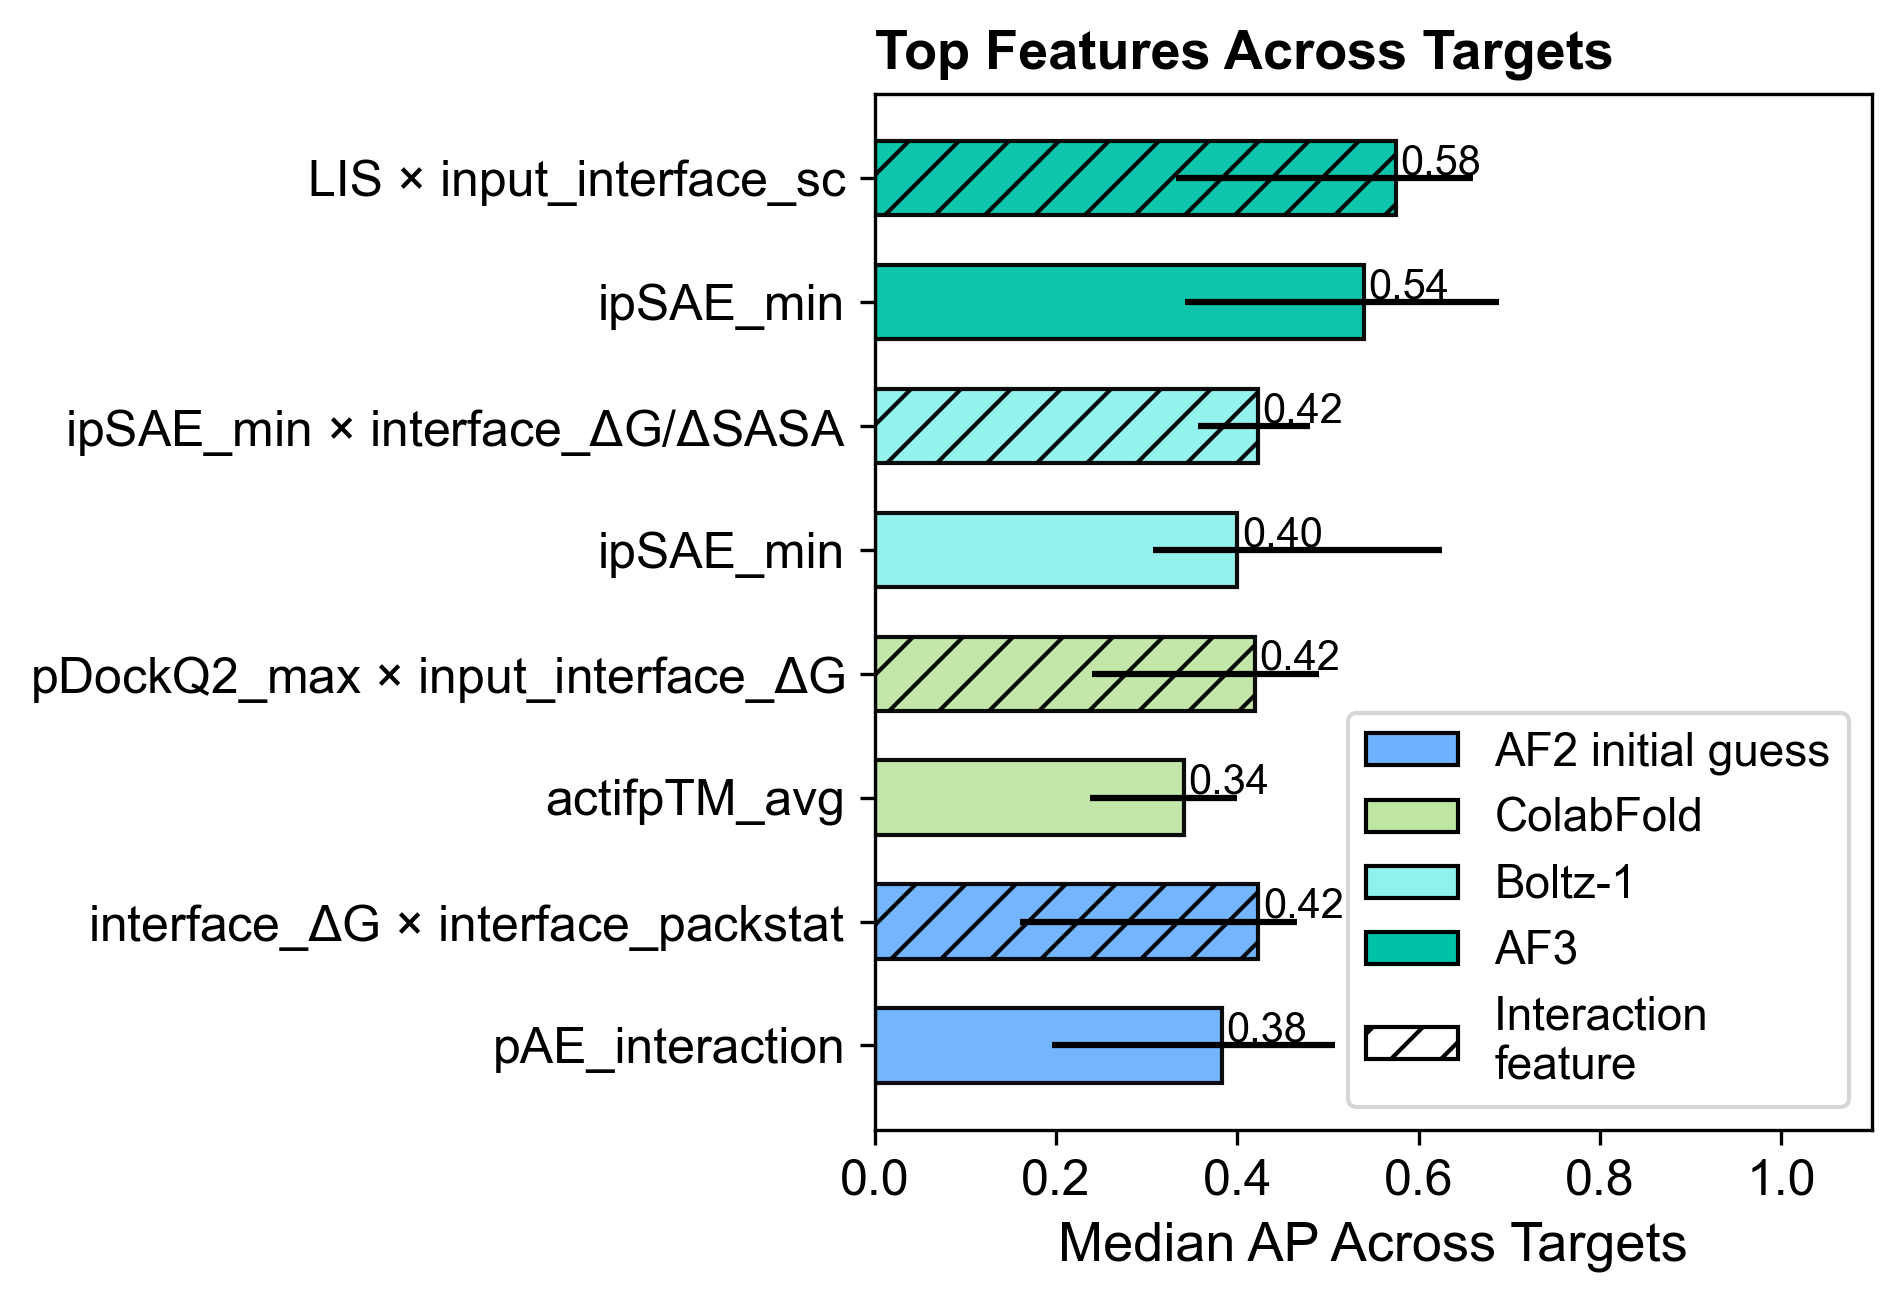

In [ ]:
# --- YOUR DATA ---
# df_full should be your DataFrame with these columns:
# ['feature', 'is_interaction', 'model_tag', 'target_id', 'AP', 'lower_is_better']

# Color map
color_map = {
    'af2': '#6db1ff',
    'colab':         '#C0E6A4',
    'boltz1':           '#8EF3ED',
    'af3':               '#00c2a8',
}
label_map = {
    'af2':    'AF2 initial guess',
    'colab':  'ColabFold',
    'boltz1': 'Boltz-1',
    'af3':    'AF3',
}

def prettify_feature_name(f):
    f = f.replace('af3_', '').replace('af2_', '')
    f = f.replace('colab_', '').replace('boltz1_', '')
    f = f.replace('rosetta_', '').replace('rosetta', '')
    f = f.replace('*', ' × ')
    f = f.replace("dG_SASA_ratio", r'$\Delta$G/$\Delta$SASA')
    f = f.replace("dG", r'$\Delta$G')
    f = f.replace("sap_delta", r'$\Delta$SAP')
    f = f.replace("actifptm", "actifpTM")
    f = f.replace("pae", "pAE")
    return f

# --- Find top feature per model/kind ---
rows = []
for model in color_map.keys():
    for is_inter in [False, True]:
        subset = ap_per_target_df[(ap_per_target_df['model_tag'] == model) & (ap_per_target_df['is_interaction'] == is_inter)]
        # Find feature with highest median AP
        if subset.empty: continue
        medians = subset.groupby('feature')['AP'].median()
        top_feature = medians.idxmax()
        feat_df = subset[subset['feature'] == top_feature]
        row = {
            'feature': prettify_feature_name(top_feature),
            'model': label_map[model],
            'is_interaction': is_inter,
            'median': feat_df['AP'].median(),
            'q25': np.nanpercentile(feat_df['AP'], 25),
            'q75': np.nanpercentile(feat_df['AP'], 75)
        }
        rows.append(row)

df_plot = pd.DataFrame(rows)
# Sort: group by model, singles first
df_plot['order'] = df_plot['model'].map({v: i for i, v in enumerate(label_map.values())})
df_plot['kind_order'] = df_plot['is_interaction'].map({False: 0, True: 1})
df_plot = df_plot.sort_values(['order', 'kind_order'], ascending=[True, True]).reset_index(drop=True)

# --- Plot ---
plt.figure(figsize=(6.5, 4.5),dpi=300)
y_pos = np.arange(len(df_plot))
bar_colors = [color_map[list(label_map.keys())[list(label_map.values()).index(model)]] for model in df_plot['model']]

for i, (kind, color) in enumerate(zip(df_plot['is_interaction'], bar_colors)):
    hatch = '//' if kind else ''
    plt.barh(
        i, df_plot['median'].iloc[i],
        xerr=[[df_plot['median'].iloc[i] - df_plot['q25'].iloc[i]], [df_plot['q75'].iloc[i] - df_plot['median'].iloc[i]]],
        color=color, edgecolor='black', height=0.6, hatch=hatch, capsize=0, alpha=0.95
    )
    plt.text(df_plot['median'].iloc[i] + 0.005, i+0.12, f"{df_plot['median'].iloc[i]:.2f}", va='center', fontsize=10)

plt.yticks(y_pos, df_plot['feature'])
plt.xlabel('Median AP Across Targets')
plt.xlim(0, 1.1)
plt.title('Top Features Across Targets', loc='left', fontweight='bold')

legend_elements = [
    Patch(facecolor=color_map[k], edgecolor='black', label=label_map[k]) for k in color_map
]
interaction_patch = Patch(facecolor='white', edgecolor='black', hatch='//', label="Interaction \nfeature")
plt.legend(handles=legend_elements + [interaction_patch], loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()


# Precision at different thresholds

### Takes about 8 min

In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.model_selection import LeaveOneGroupOut

# --- Data Loading & Setup ---
df = pd.read_csv(INPUT_CSV)
df['binder'] = df['binder'].astype(int)

features = [
    "af3_LIS*input_rosetta_interface_sc",
    "af3_ipSAE_min*af3_rosetta_interface_dG_SASA_ratio",
    "af3_ipSAE_min",
    "af2_pae_interaction",
    "af3_iptm_model_0"
]

# --- Precompute any interaction columns ---
for feat in features:
    if '*' in feat and feat not in df.columns:
        a, b = feat.split('*')
        df[feat] = (
            pd.to_numeric(df[a], errors='coerce').fillna(0)
            * pd.to_numeric(df[b], errors='coerce').fillna(0)
        )

recall_types = ["recall_0.2", "recall_0.4", "max_f1"]

# --- Results dict including AP ---
results = {
    **{rec: {feat: [] for feat in features} for rec in recall_types},
    "ap": {feat: [] for feat in features}
}

groups = df['target_id'].values
y = df['binder'].values
X = df[features]

# --- Direction Helper (on train) ---
def get_direction(x_train, y_train):
    ap_pos = average_precision_score(y_train, x_train)
    ap_neg = average_precision_score(y_train, -x_train)
    # If AP is higher when scores are negated, then lower values indicate binder
    return not (np.nanmax([ap_pos, 0]) >= np.nanmax([ap_neg, 0]))

# --- Threshold Helpers ---
def get_threshold_for_recall(x, y, recall_target, lower_better):
    thr_vals = np.sort(np.unique(x))
    if not lower_better:
        thr_vals = thr_vals[::-1]
    for t in thr_vals:
        preds = (x <= t) if lower_better else (x >= t)
        if recall_score(y, preds.astype(int), zero_division=0) >= recall_target:
            return t
    return np.nan

def get_threshold_for_f1(x, y, lower_better):
    best_thr, best_f1 = np.nan, -1.0
    for t in np.unique(x):
        preds = (x <= t) if lower_better else (x >= t)
        f1 = f1_score(y, preds.astype(int), zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, t
    return best_thr

# --- CV Setup ---
logo = LeaveOneGroupOut()

thresholds = {rec: {feat: [] for feat in features} for rec in recall_types}

for train_idx, test_idx in logo.split(X, y, groups):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    for feat in features:
        xt = X_tr[feat].fillna(0).values
        xe = X_te[feat].fillna(0).values

        # Determine direction and compute AP on test set
        lower_better = get_direction(xt, y_tr)
        scores_for_ap = -xe if lower_better else xe
        try:
            ap_score = average_precision_score(y_te, scores_for_ap)
        except ValueError:
            ap_score = np.nan
        results["ap"][feat].append(ap_score)

        # Skip thresholding if no variability
        if len(np.unique(xt)) < 2:
            for rec in recall_types:
                results[rec][feat].append(np.nan)
                thresholds[rec][feat].append(np.nan)
            continue

        thr_02 = get_threshold_for_recall(xt, y_tr, 0.2, lower_better)
        thr_04 = get_threshold_for_recall(xt, y_tr, 0.4, lower_better)
        thr_f1 = get_threshold_for_f1(xt, y_tr, lower_better)

        for rec, thr in zip(recall_types, [thr_02, thr_04, thr_f1]):
            thresholds[rec][feat].append(thr)  # store threshold
            if np.isnan(thr):
                results[rec][feat].append(np.nan)
            else:
                preds = ((xe <= thr) if lower_better else (xe >= thr)).astype(int)
                p = precision_score(y_te, preds, zero_division=0)
                results[rec][feat].append(p * 100)

# --- Build summary DataFrame including thresholds ---
summary = []
for feat in features:
    for rec in recall_types:
        arr = np.array(results[rec][feat])
        thr_arr = np.array(thresholds[rec][feat])
        summary.append({
            'feature': feat,
            'metric': rec,
            'median': np.nanmedian(arr),
            'q25': np.nanpercentile(arr, 25),
            'q75': np.nanpercentile(arr, 75),
            'median_thr': np.nanmedian(thr_arr),
            'thr_q25': np.nanpercentile(thr_arr, 25),
            'thr_q75': np.nanpercentile(thr_arr, 75),
        })
    # AP (no thresholds)
    arr_ap = np.array(results["ap"][feat])
    summary.append({
        'feature': feat,
        'metric': 'AP',
        'median': np.nanmedian(arr_ap),
        'q25': np.nanpercentile(arr_ap, 25),
        'q75': np.nanpercentile(arr_ap, 75),
        'median_thr': np.nan,
        'thr_q25': np.nan,
        'thr_q75': np.nan,
    })

summary_df = pd.DataFrame(summary)

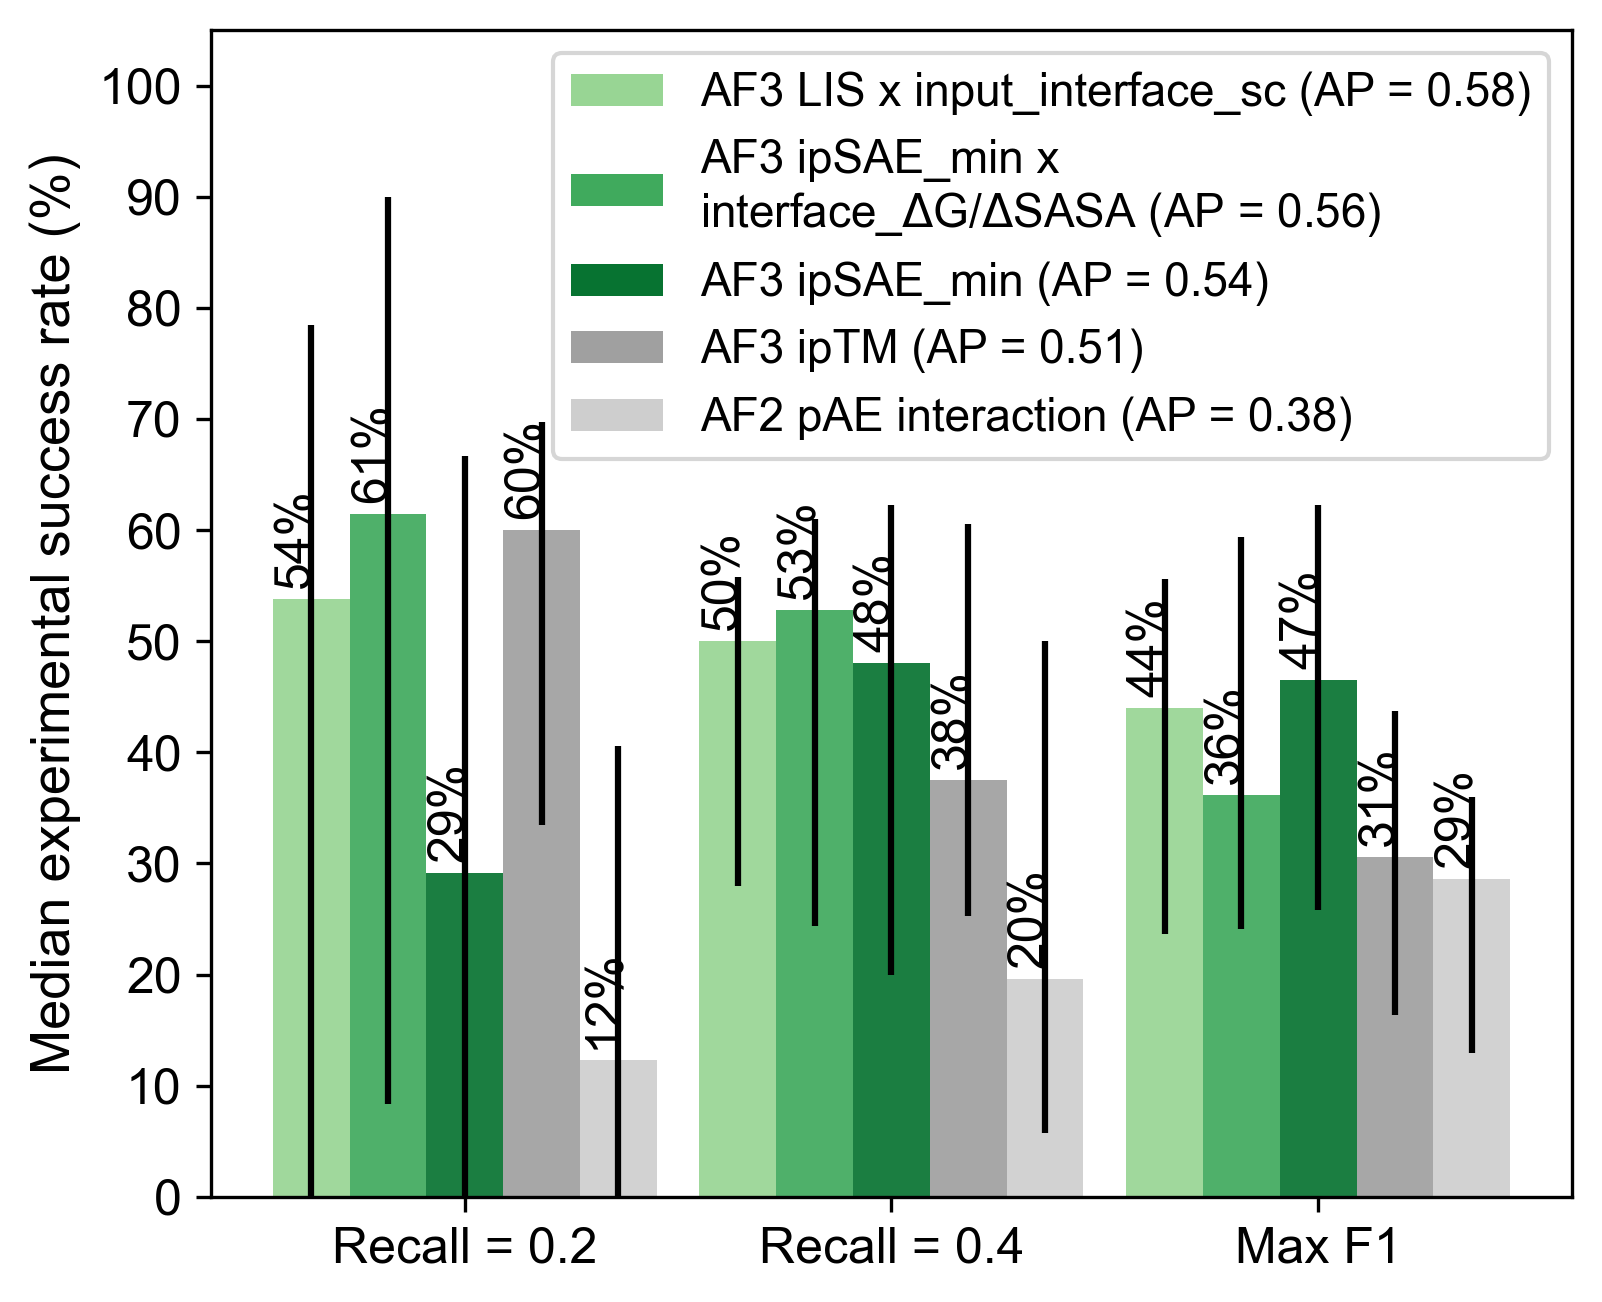

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumes you already have `summary_df` in your namespace ---
# summary_df must have columns: ['feature','metric','median','q25','q75']
# where metric ∈ {"recall_0.2","recall_0.4","max_f1","AP"}

# 1) Define your groups and feature ordering
recall_types = ["recall_0.2", "recall_0.4", "max_f1"]
feature_order = [
    "af3_LIS*input_rosetta_interface_sc",
    "af3_ipSAE_min*af3_rosetta_interface_dG_SASA_ratio",
    "af3_ipSAE_min",
    "af3_iptm_model_0",
    "af2_pae_interaction"
]

# 2) Color & label maps
greens = plt.cm.Greens(np.linspace(0.4, 0.85, 3))
feature_colors = {
    "af3_LIS*input_rosetta_interface_sc": greens[0],
    "af3_ipSAE_min*af3_rosetta_interface_dG_SASA_ratio": greens[1],
    "af3_ipSAE_min": greens[2],
    "af3_iptm_model_0": "#a0a0a0",
    "af2_pae_interaction": "#cecece"
}
feature_labels = {
    "af3_LIS*input_rosetta_interface_sc": "AF3 LIS x input_interface_sc",
    "af3_ipSAE_min*af3_rosetta_interface_dG_SASA_ratio": "AF3 ipSAE_min x \n"+r"interface_$\Delta$G/$\Delta$SASA",
    "af3_ipSAE_min": "AF3 ipSAE_min",
    "af3_iptm_model_0": "AF3 ipTM",
    "af2_pae_interaction": "AF2 pAE interaction"
}

# 3) Build `results` dict for recall‐based metrics
results = {}
for rec in recall_types:
    df_sub = (
        summary_df[summary_df['metric'] == rec]
        .set_index('feature')
        .loc[feature_order]
        .reset_index()
        .rename(columns={'median': 'median_precision'})
    )
    # now each dict has keys: feature, median_precision, q25, q75
    results[rec] = df_sub.to_dict(orient='records')

# 4) Extract median AP per feature
ap_df = summary_df[summary_df['metric'] == 'AP']
ap_medians = ap_df.set_index('feature')['median'].to_dict()
# e.g. { "af3_ipSAE_min": 0.82, ... }

# 5) Plot
fig, ax = plt.subplots(figsize=(5.5, 4.5),dpi=300)
width = 0.18
group_centers = list(range(len(recall_types)))

for i, rec in enumerate(recall_types):
    data = results[rec]  # in the order of feature_order
    for j, d in enumerate(data):
        xpos = i + (j - (len(feature_order)-1)/2) * width
        color = feature_colors[d['feature']]

        # draw bar + errorbar
        ax.bar(
            xpos,
            d['median_precision'],
            yerr=[[d['median_precision'] - d['q25']],
                  [d['q75'] - d['median_precision']]],
            capsize=0,
            width=width,
            color=color,
            alpha=0.92,
            error_kw={'ecolor':'black','elinewidth':1.5}
        )

        # annotate the median %
        ax.text(
            xpos-0.035,
            d['median_precision'] + 1,
            f"{d['median_precision']:.0f}%",
            ha='center', va='bottom',
            rotation=90,
            zorder=3
        )

        # add one legend entry per feature at the first group
        if i == 0:
            label = f"{feature_labels[d['feature']]} (AP = {ap_medians[d['feature']]:.2f})"
            ax.bar(0, 0, color=color, label=label)

# 6) Final formatting
xticklabels = [
    rec.replace("recall_", "Recall = ").replace("max_f1", "Max F1")
    for rec in recall_types
]
ax.set_xticks(group_centers)
ax.set_xticklabels(xticklabels)
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylim(0, 105)
ax.set_ylabel('Median experimental success rate (%)')
ax.legend(title="", loc='upper right')
plt.tight_layout()
plt.show()

# Threshold vs Recall/Precision

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# ----------- Configurable section -----------
df = pd.read_csv(INPUT_CSV)
df['binder'] = df['binder'].astype(int)

features = [
    "af3_ipSAE_min",
    "af3_ipSAE_min*af3_rosetta_interface_dG_SASA_ratio",
    "af3_LIS*input_rosetta_interface_sc"
    
]

feature_labels = {
    "af3_ipSAE_min": "AF3 ipSAE_min",
    "af3_ipSAE_min*af3_rosetta_interface_dG_SASA_ratio": r"AF3 ipSAE_min x interface_$\Delta$G/$\Delta$SASA",
    "af3_LIS*input_rosetta_interface_sc": "AF3 LIS x input_interface_sc",
}
colors = plt.cm.Greens(np.linspace(0.3, 0.82, len(features)))
# --------------------------------------------

# Direction helper
from sklearn.metrics import average_precision_score
def get_direction(col, y):
    ap_high = average_precision_score(y, col)
    ap_low = average_precision_score(y, -col)
    return False if (not np.isnan(ap_high) and ap_high >= ap_low) or np.isnan(ap_low) else True

In [35]:
# ─── Block 1: COMPUTE ALL METRICS ─────────────────────────────────────────────
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

metrics = {}

for feat in features:
    # build the feature vector (handle interactions)
    if "*" in feat:
        f1, f2 = feat.split("*")
        x = (pd.to_numeric(df[f1], errors='coerce').fillna(0) *
             pd.to_numeric(df[f2], errors='coerce').fillna(0))
    else:
        x = pd.to_numeric(df[feat], errors='coerce').fillna(0)
    y = df['binder'].values
    
    # skip if trivial
    if len(np.unique(x)) < 2:
        continue

    # Decide threshold direction
    lower_better = get_direction(x, y)
    thr_vals = np.unique(np.sort(x))
    
    P, R, F = [], [], []
    for thr in thr_vals:
        if lower_better:
            preds = (x <= thr).astype(int)
        else:
            preds = (x >= thr).astype(int)
        P.append(precision_score(y, preds, zero_division=0))
        R.append(recall_score(y, preds, zero_division=0))
        F.append(f1_score(y, preds, zero_division=0))

    F = np.array(F)
    best_idx = np.nanargmax(F)
    
    # Save to dict
    metrics[feat] = {
        "thresholds": thr_vals,
        "precision": np.array(P),
        "recall":    np.array(R),
        "best_thr":  thr_vals[best_idx],
        "lower_is_better":lower_better
    }


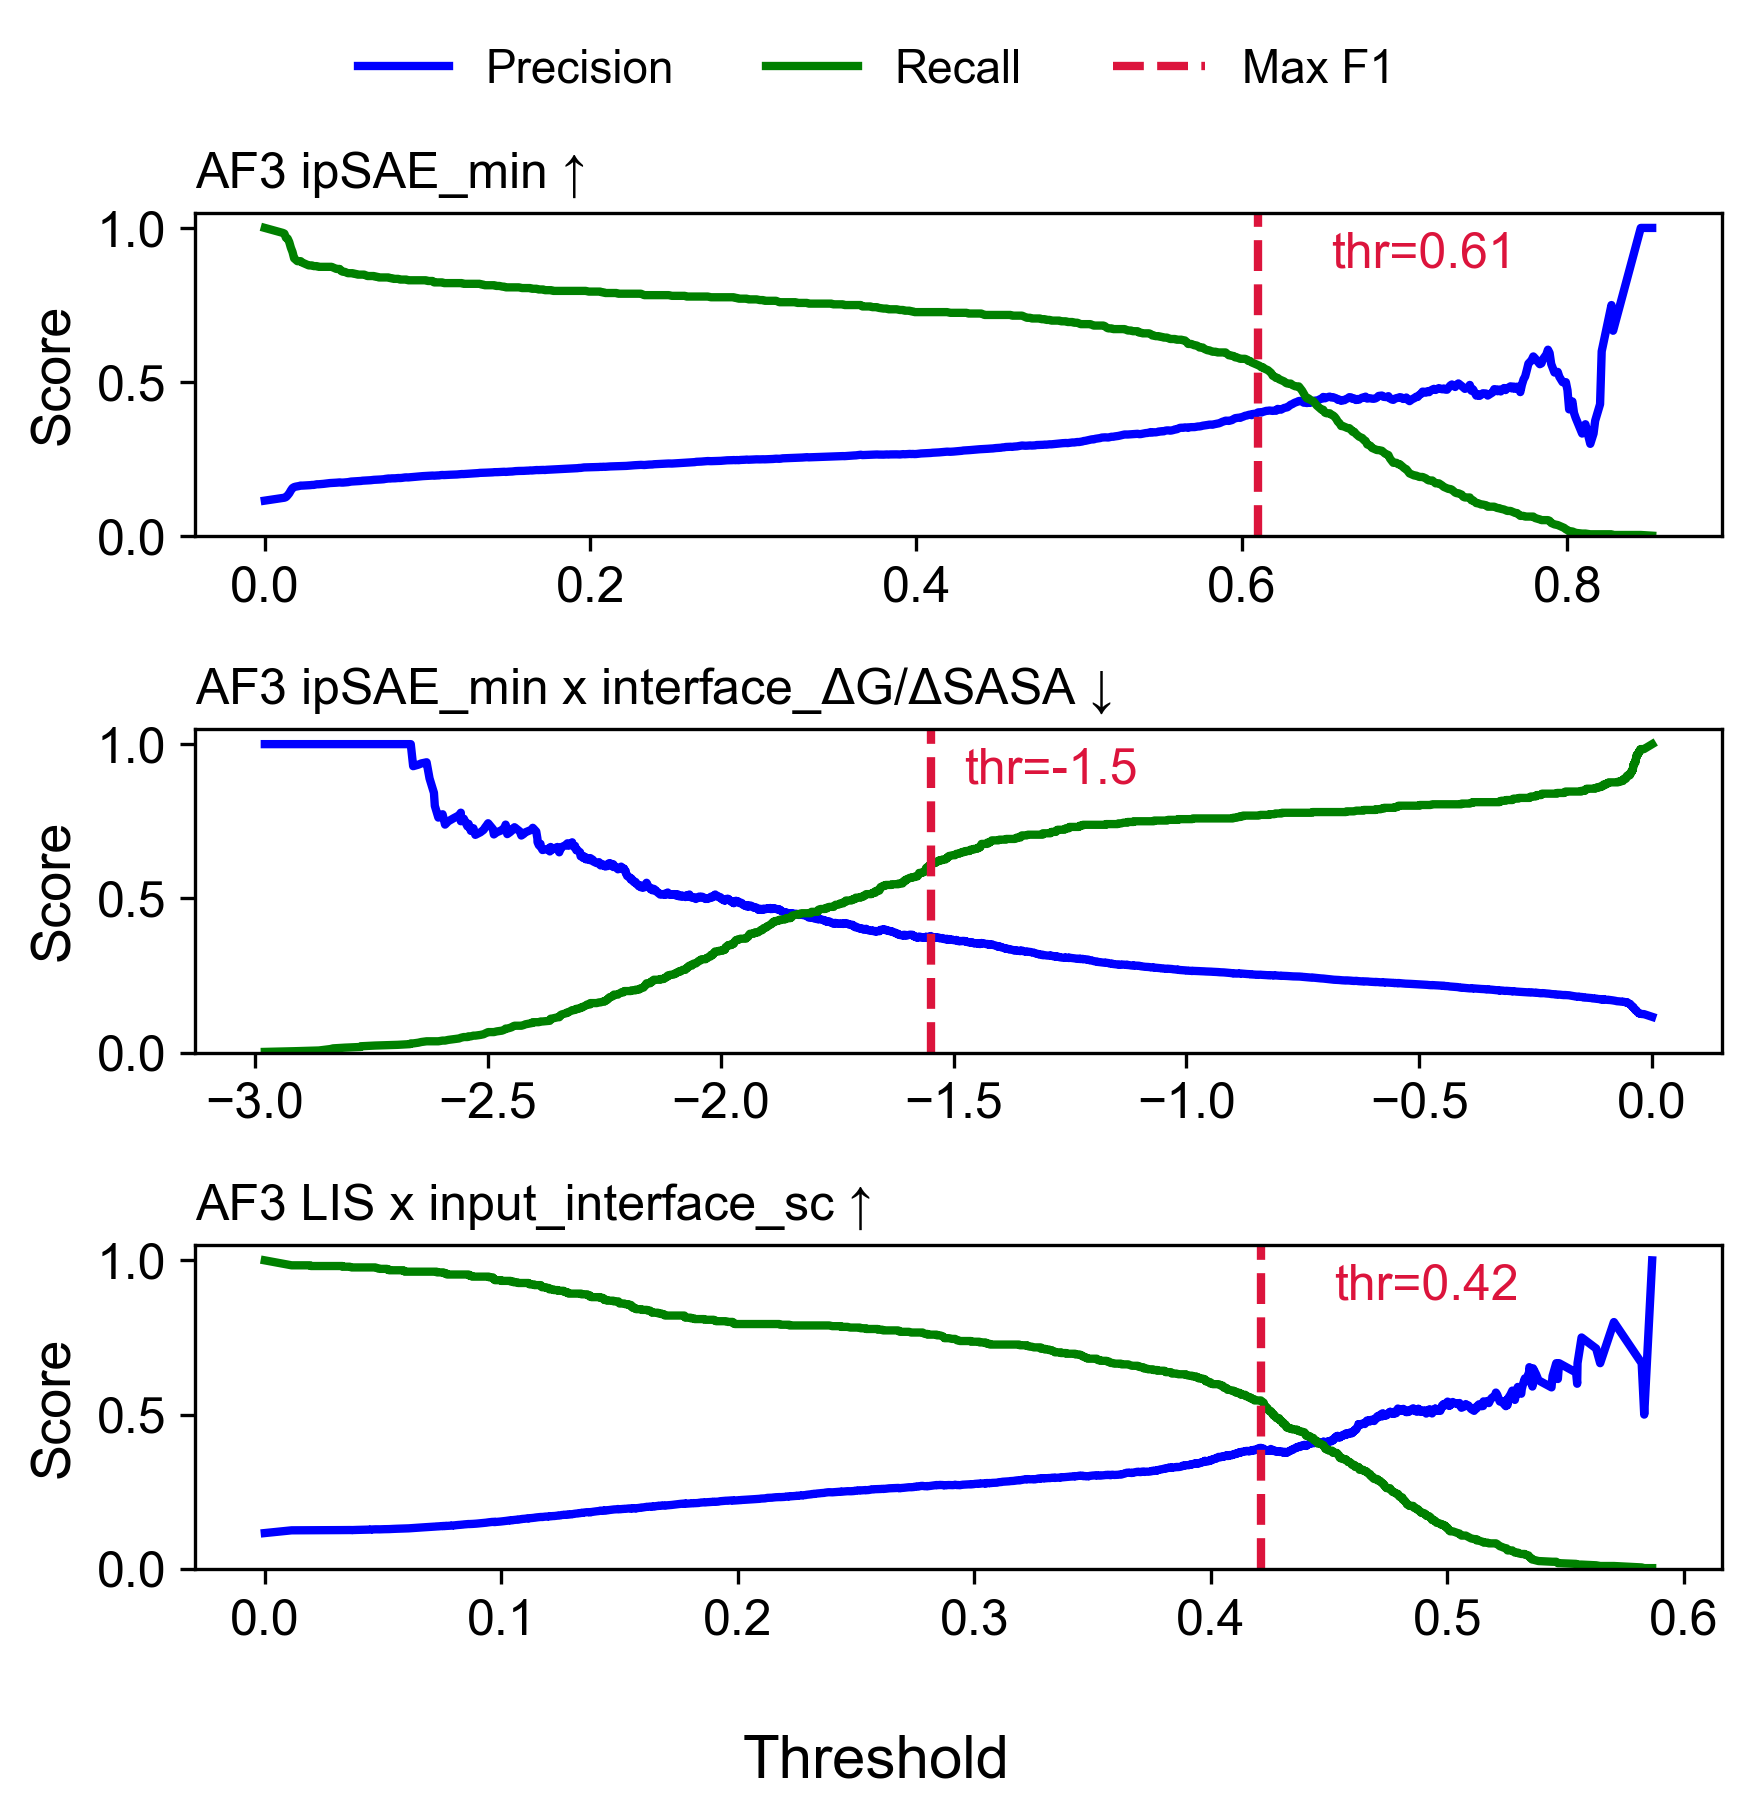

In [36]:
## ─── Block 2: PLOT WITH INDIVIDUAL TICKS & ONE COMMON LABEL ─────────────────
import matplotlib.pyplot as plt
#fig, axes = plt.subplots(3, 1, figsize=(5, 6), sharex=False,dpi=300)
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=False,dpi=300)
axes = axes.flatten()

for ax, feat in zip(axes, features):
    if feat not in metrics:
        ax.set_visible(False)
        continue

    data = metrics[feat]
    thr   = data["thresholds"]
    P     = data["precision"]
    R     = data["recall"]
    best  = data["best_thr"]
    lower_is_better = data["lower_is_better"]

    ax.plot(thr, P, label="Precision", lw=2, color="blue")
    ax.plot(thr, R, label="Recall",    lw=2, color="green")
    ax.axvline(
        best, ls="--", lw=2, color="crimson", label="Max F1"
    )
    ax.text(
        best + abs(best)/6, 0.8,
        f"thr={best:.2g}",
        color="crimson",
        ha="center",
        va="bottom",
        transform=ax.get_xaxis_transform()
    )

    # ←—— here's the only bit that changes:
    
    arrow = "↓" if lower_is_better else "↑"
    ax.set_title(f"{feature_labels.get(feat, feat)} {arrow}",
                 loc="left", fontsize=12)

    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.05)

# Single, figure-level x-label
fig.supxlabel("Threshold")

# Single, figure-level legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 1),
           frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Threshold/precision/recall vs data set size

# Takes about 15 min

In [45]:
import pandas as pd
import numpy as np
from itertools import combinations
from pathlib import Path
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Load data ---
INPUT_CSV = Path('./data/prepared_training_dataset.csv')
df = pd.read_csv(INPUT_CSV)
df['binder'] = df['binder'].astype(int)

# --- Feature ---
feat = 'af3_ipSAE_min'
higher_is_better = True

# --- Fast threshold finder ---
def fast_threshold_at_max_f1(vals, y, higher_is_better=True):
    if not higher_is_better:
        vals = -vals
    prec, rec, thr = precision_recall_curve(y, vals)
    f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
    if len(thr) == 0:
        return np.nan
    return thr[np.nanargmax(f1_scores)]

# --- Step 1: Precompute per-target thresholds ---
all_targets = sorted(df['target_id'].unique())
per_target_thresholds = {}

for t in tqdm(all_targets, desc="Per-target thresholds"):
    df_t = df[df['target_id'] == t]
    y_t = df_t['binder'].values
    if len(np.unique(y_t)) < 2:
        thr = np.nan
    else:
        vals_t = pd.to_numeric(df_t[feat], errors='coerce').fillna(0).values
        thr = fast_threshold_at_max_f1(vals_t, y_t, higher_is_better)
    per_target_thresholds[t] = thr

# --- Step 2: Evaluate all possible combinations for each holdout ---
records = []

for hold in tqdm(all_targets, desc="Evaluating combinations"):
    df_hold = df[df['target_id'] == hold]
    y_hold = df_hold['binder'].values
    if len(np.unique(y_hold)) < 2:
        continue

    other_targets = [t for t in all_targets if t != hold]

    for n in range(1, len(other_targets) + 1):
        for combo in combinations(other_targets, n):
            combo_thresholds = [per_target_thresholds[t] for t in combo if not np.isnan(per_target_thresholds[t])]
            if len(combo_thresholds) == 0:
                continue

            thr = np.median(combo_thresholds)

            vals_hd = pd.to_numeric(df_hold[feat], errors='coerce').fillna(0).values
            preds = (vals_hd >= thr).astype(int) if higher_is_better else (vals_hd <= thr).astype(int)

            records.append({
                'holdout_target': hold,
                'n_train_targets': n,
                'threshold': thr,
                'test_precision': precision_score(y_hold, preds, zero_division=0),
                'test_recall': recall_score(y_hold, preds, zero_division=0),
                'test_f1': f1_score(y_hold, preds, zero_division=0)
            })

res = pd.DataFrame(records)

Evaluating combinations: 100%|██████████| 15/15 [14:43<00:00, 58.92s/it]


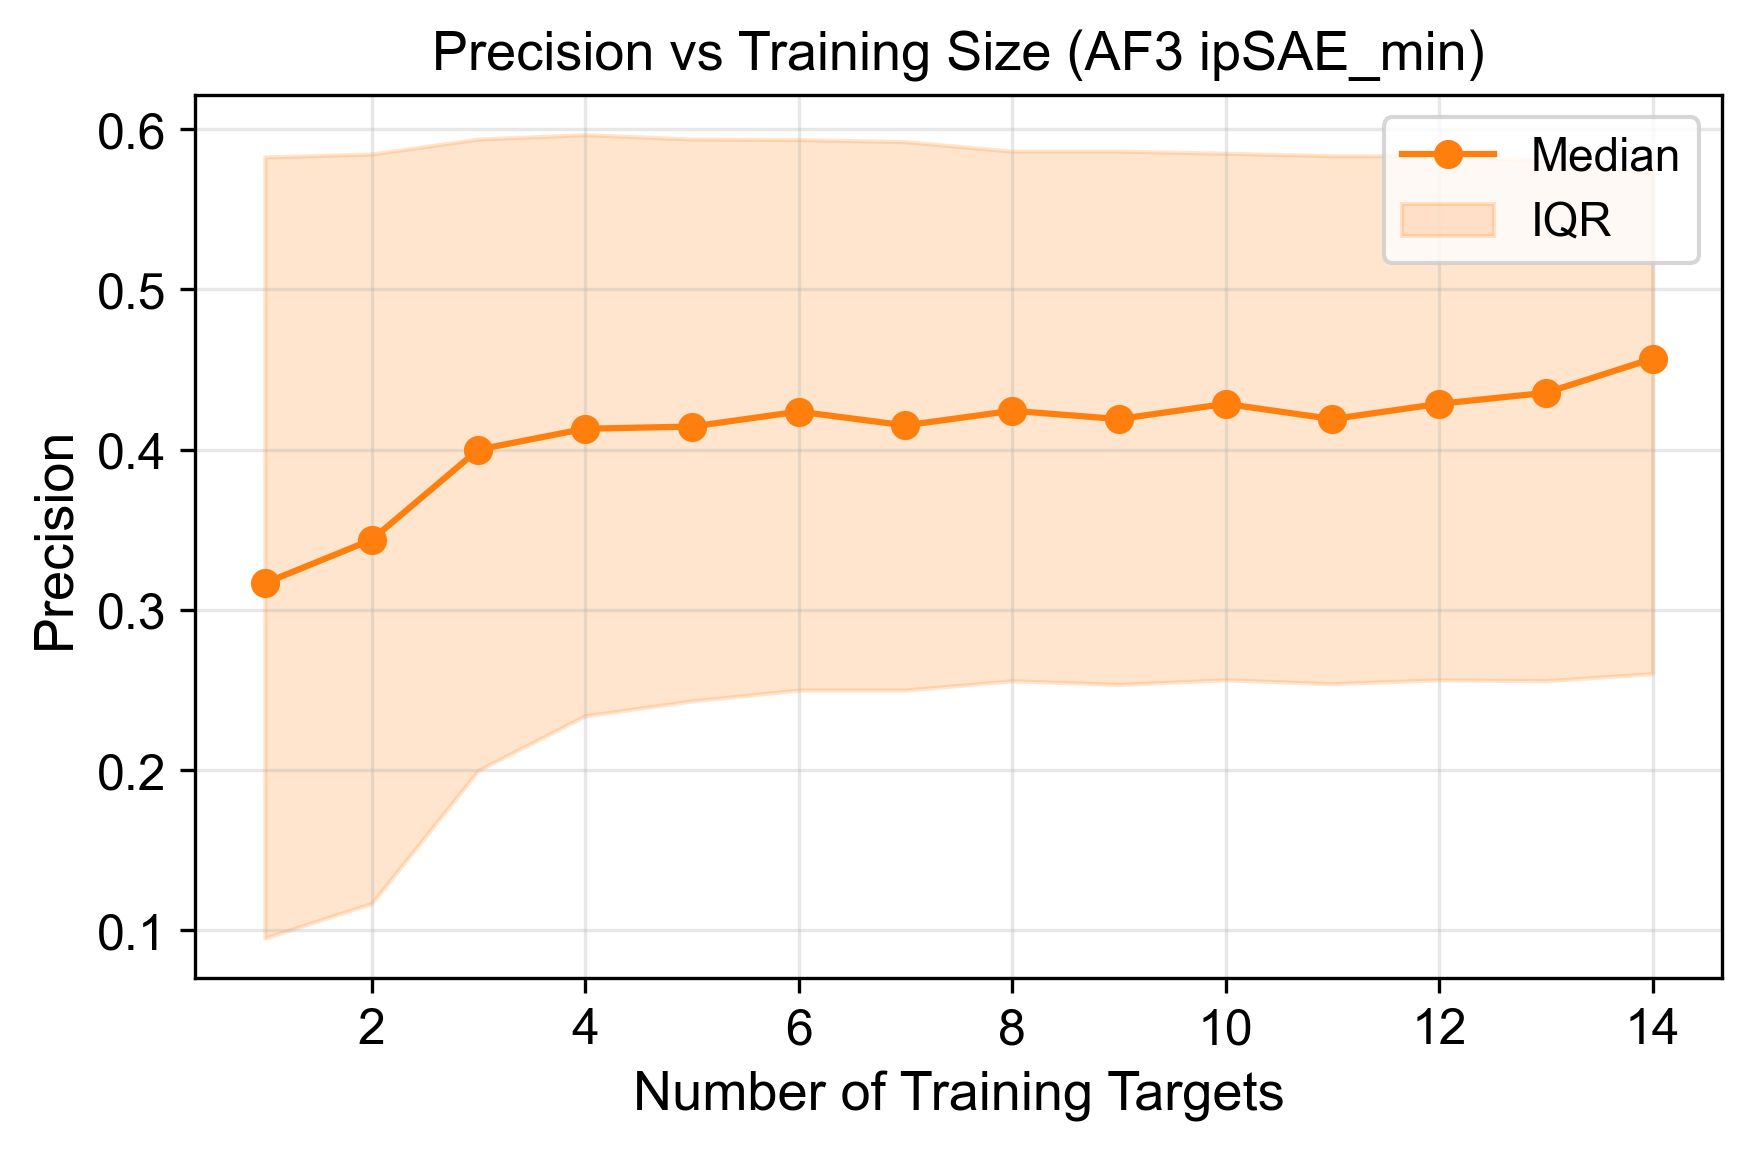

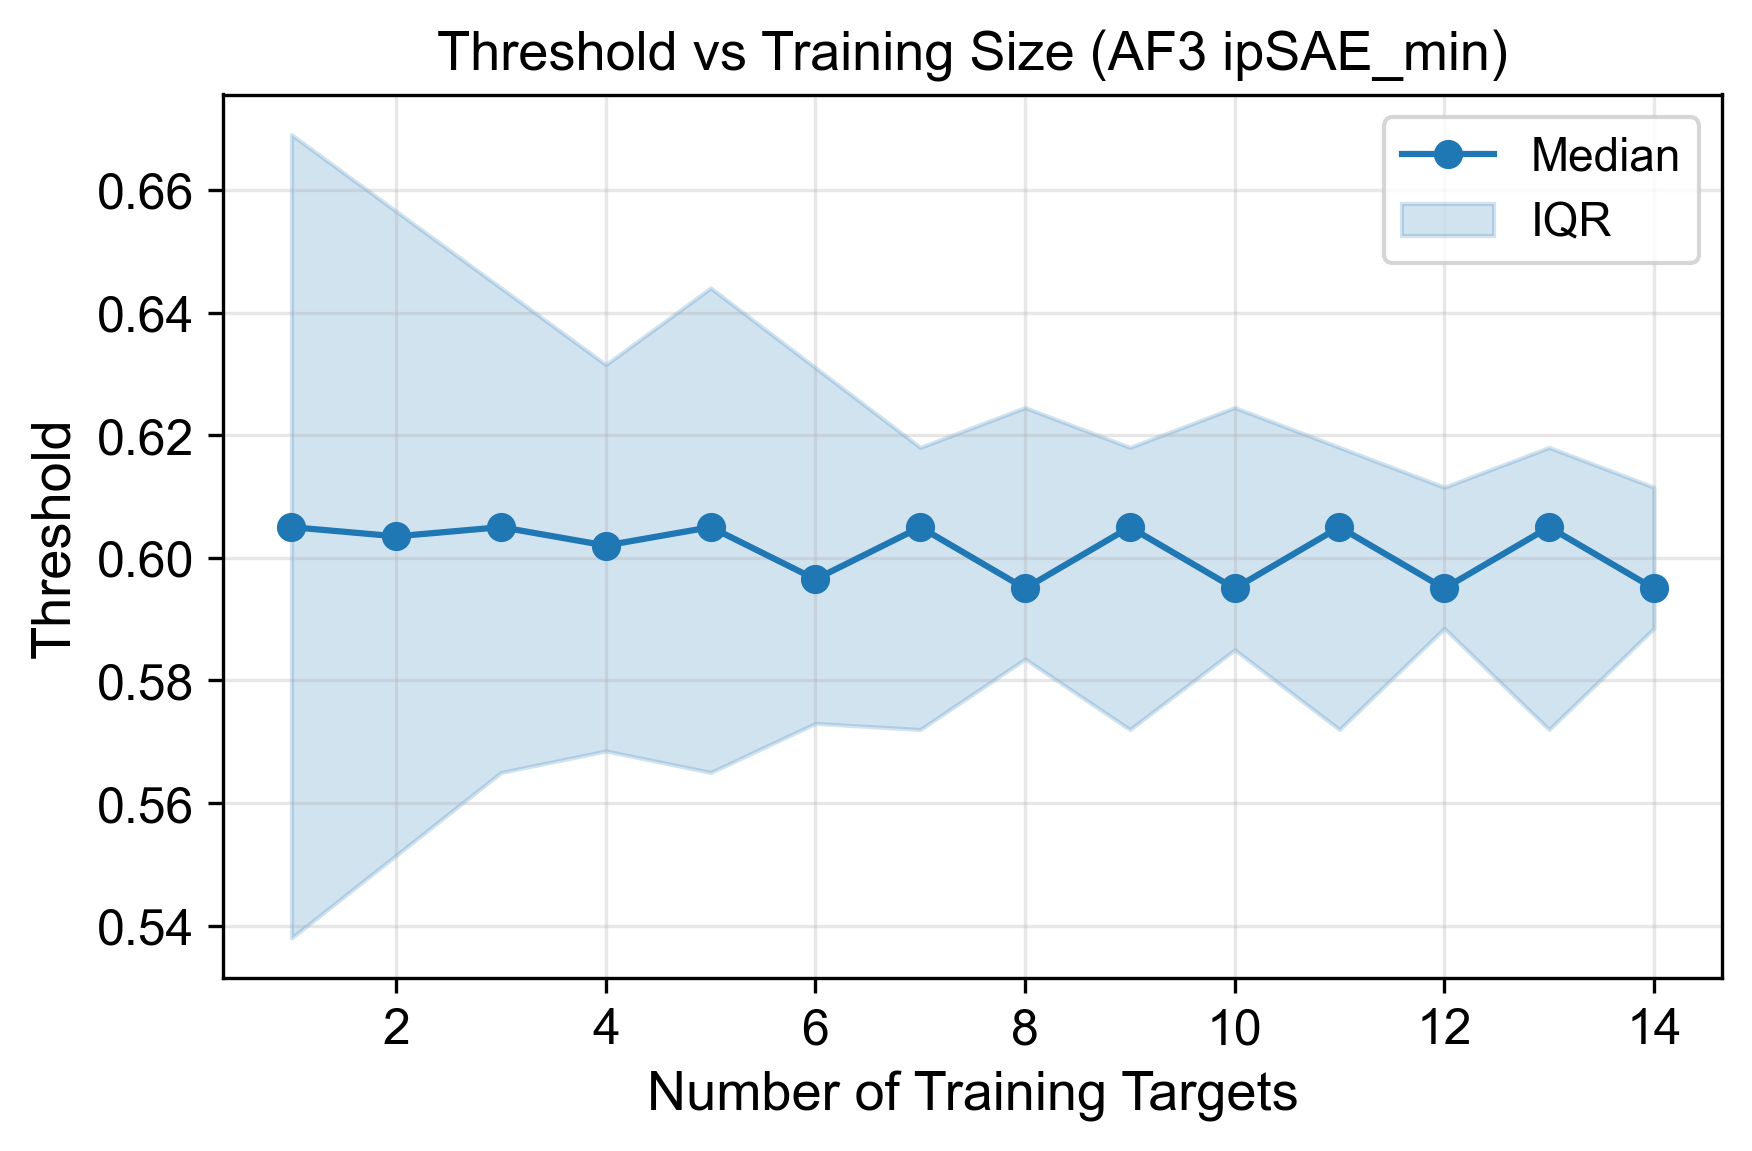

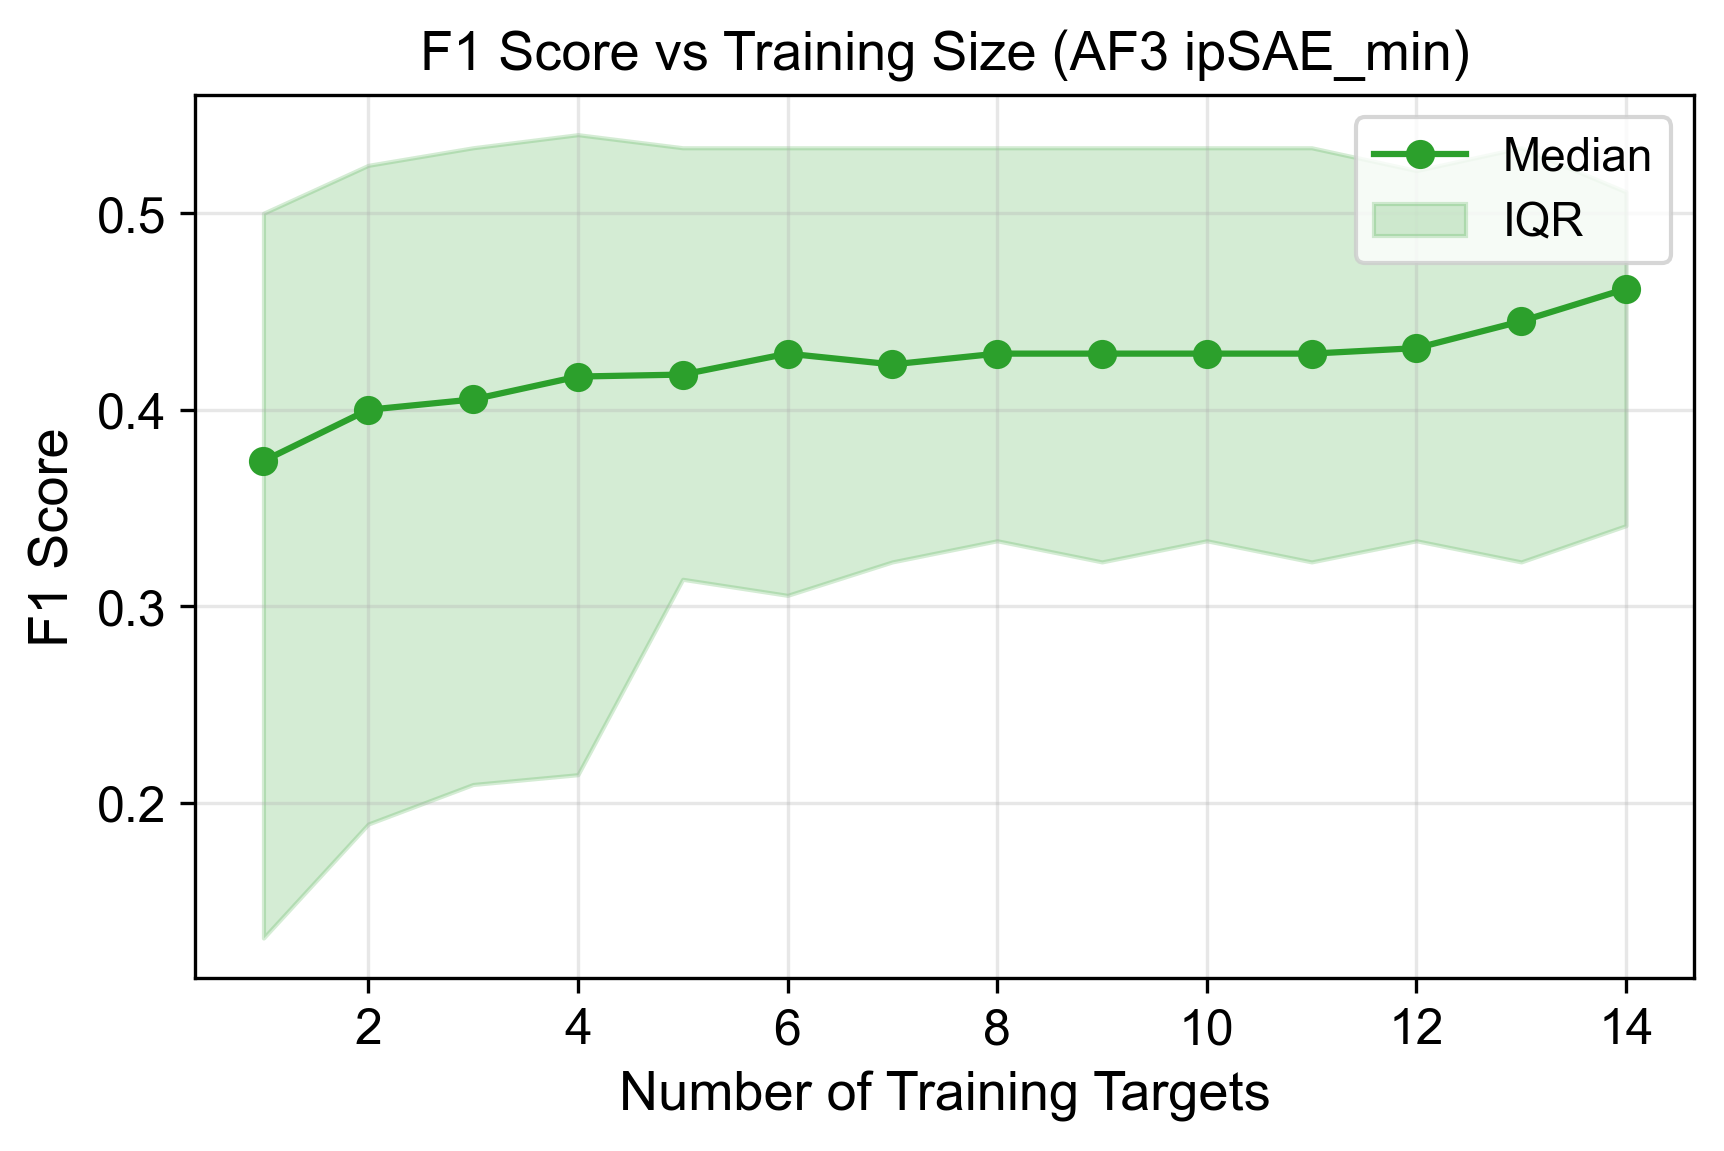

In [46]:
# --- Step 3: Plot helper ---
def plot_metric_with_variability(df, metric, ylabel, color, title):
    grouped = df.groupby('n_train_targets')[metric]
    med = grouped.median()
    q1 = grouped.quantile(0.25)
    q3 = grouped.quantile(0.75)

    plt.figure(figsize=(6, 4),dpi=300)
    plt.plot(med.index, med.values, '-o', color=color, label='Median')
    plt.fill_between(med.index, q1.values, q3.values, color=color, alpha=0.2, label='IQR')
    plt.xlabel('Number of Training Targets')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Step 4: Plots ---
plot_metric_with_variability(res, 'test_precision', 'Precision', 'C1', f'Precision vs Training Size (AF3 ipSAE_min)')
plot_metric_with_variability(res, 'threshold', 'Threshold', 'C0', f'Threshold vs Training Size (AF3 ipSAE_min)')
plot_metric_with_variability(res, 'test_f1', 'F1 Score', 'C2', f'F1 Score vs Training Size (AF3 ipSAE_min)')